# The Association between Urbanization and Northern Cardinal Observation in United States Counties 
By Ian Brandenburg (2304791) for Coding 1 and Data Analysis 2 Term Project

[GITHUB REPO LINK](https://github.com/Iandrewburg/DA2_TERM_PROJECT)


# Introduction
---

The Northern Cardinal (Cardinalis cardinalis) is one of the most observed bird species in the U.S., commonly found in backyards and well-recognized nationwide1. It is referred to as a ‘backyard’ bird species, which means it is very commonly found in rural and urbanized habitats. This study investigates how human populations and urban development are associated with Northern Cardinal observation frequencies in U.S. counties. Given their adaptation to certain human-developed areas for food sourcing, this research examines the effect of urban development and population density on observation incidence. Focusing on 2022 data, the study analyses County-Level Rural-Urban Continuum Codes, Urban Influence Codes, Economic Typology, Natural Rate of Change, and Immigration Rates. The questions this research project aims to address are: What effect does urbanization have on Northern Cardinal sightings in the U.S.? It hypothesizes that more developed counties will record higher Northern Cardinal observations. 

---

# **LIBRARIES**
---

In [1]:
import zipfile
import os
import io
import sys
import warnings
import requests

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# GET DATA (Only for documentation, no longer runable)
---

The following functions were used to load the data in as a text file, convert to a csv, then zip the csv.

This was done because the method eBird uses to send data is through text files, as their datafiles are very large. 

Since this process only needs to occur once, these functions are no longer useful or needed, but for the purpose of documenting work, they have been saved as MDs. 

def txt_to_csv(input_file_name, output_file_name, delimiter='\t', header=True):
    # Get the current working directory
    cwd = os.getcwd()

    # Create full file paths
    input_file_path = os.path.join(cwd, input_file_name)
    output_file_path = os.path.join(cwd, output_file_name)

    # Read the text file
    header_row = 0 if header else None
    df = pd.read_csv(input_file_path, delimiter=delimiter, header=header_row)

    # Save the dataframe to a CSV file
    df.to_csv(output_file_path, index=False)

txt_to_csv('NORCAR_JAN.txt', 'NORCAR_JAN.csv')
txt_to_csv('NORCAR_APRIL.txt', 'NORCAR_APRIL.csv')
txt_to_csv('NORCAR_JUL.txt', 'NORCAR_JUL.csv')
txt_to_csv('NORCAR_OCT.txt', 'NORCAR_OCT.csv')

def zip_csv(input_csv, output_zip):
    # Read the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # No need to identify and filter by top species; we skip that step

    # Create a buffer to write the DataFrame to
    buffer = io.StringIO()
    df.to_csv(buffer, index=False)
    buffer.seek(0)  # Rewind the buffer

    # Zip the buffered CSV
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.writestr(os.path.basename(input_csv), buffer.getvalue())
        

zip_csv('NORCAR_JAN.csv', 'NORCAR_JAN.zip')
zip_csv('NORCAR_APRIL.csv', 'NORCAR_APRIL.zip')
zip_csv('NORCAR_JUL.csv', 'NORCAR_JUL.zip')
zip_csv('NORCAR_OCT.csv', 'NORCAR_OCT.zip')

# **1.** PROCESS AND CLEAN THE DATA
---

This project merged two datasets. The first, from Cornell University’s Ornithology Lab’s [eBird](https://ebird.org/data/download/ebd) project, providing Northern Cardinal observations by U.S. counties. Access was granted upon request, and data from January, April, July, and October 2022 were chosen to manage large file sizes and minimize seasonal biases, totalling 982,667 observations. Data cleaning involved aggregating data at the county level, retaining total observation counts, average observation duration, and effort distance. These variables, showing significant skewness, underwent log-transformation, including the key observation count variable for regression analysis. Appendix includes histograms of these variables before and after their log transformation (Plots 1-3). Nine states with minimal Northern Cardinal observations and counties with fewer than 10 observations in 2022 were dropped. Additionally, the top and bottom 1% of the observation counts were dropped, resulting in 2,288 aggregated counties in the cleaned dataset.

The second dataset, from the United States Department of Agriculture [USDA](https://www.ers.usda.gov/data-products/county-level-data-sets/county-level-data-sets-download-data/), contained county population and urbanization, including data on 3,143 counties. It required minimal cleaning, with no need for row eliminations due to missing values. The cleaning process primarily involved narrowing down to key columns: Rural Urban Continuum Code, Urban Influence, Economic Typology Code, Natural Rate of Change, and Net Immigration Rate.

The Rural-Urban Continuum Codes classify counties on a 1-9 scale, with Code 1 representing highly urbanized areas (over 1 million population) and Code 9 indicating rural areas (under 2,500 population, not metro-adjacent). Urban Influence Codes extend this categorization with a 1-12 range, where 1 is the most urban and 12 the most rural. More details of both codes will be found in Table 1 and Table 2. Economic Typology Codes identify the primary economy of a county: 0 for non-specialized, 1 for Farm, 2 for Mining, 3 for Manufacturing, 4 for Federal/State Government, and 5 for Recreation Dependent. The net immigration rate measures population movement in and out of counties, while the natural rate of change measures the rate of births versus deaths. These rates, showing normal distribution, along with categorical development codes being converted to dummy variables, were used in regression models analysing Northern Cardinal observation counts. During the merging process, null and infinite values were converted to ‘NaN’ (of which, there were below 10 missing values), and then filled with the mean value of their column. After merging the datasets, the study included 2,190 observations. The appendix provides detailed code descriptions distribution charts for the categorical county code variables and continuous variables.

---

## **1.1** BIRD DATA
---

### **1.1.1** Read the Data in from Links
---

n = 982,667

columns = 50

In [2]:
def read_csv_from_zip_url(url):
    """
    This function obtains a zipped csv from a URL. 
    It is assumed that there is only one csv in the zipped folder. 
    Additionally, this function reads the csv into a variable instead of loading a csv into your operating system. 
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        csv_file_name = zipf.namelist()[0]
        with zipf.open(csv_file_name) as csv_file:
            return pd.read_csv(csv_file)
        
# read the CSVs in from URLs
NORCAR_JAN = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/Data/Bird_Observation_Data/NORCAR_JAN.zip')
NORCAR_APRIL = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/Data/Bird_Observation_Data/NORCAR_APRIL.zip')
NORCAR_JUL = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/Data/Bird_Observation_Data/NORCAR_JUL.zip')
NORCAR_OCT = read_csv_from_zip_url('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/Data/Bird_Observation_Data/NORCAR_OCT.zip')

# concat each of the dataframes
NORCAR_DATA = pd.concat([NORCAR_JAN, NORCAR_APRIL, NORCAR_JUL, NORCAR_OCT], ignore_index=True)

# breifly take a look at the dataframe
print(NORCAR_DATA.columns)
NORCAR_DATA


C:\Users\iandr\AppData\Local\Temp\ipykernel_35408\2899226746.py:11: DtypeWarning: Columns (7,8,9,24) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\iandr\AppData\Local\Temp\ipykernel_35408\2899226746.py:11: DtypeWarning: Columns (7,8,9,24) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\iandr\AppData\Local\Temp\ipykernel_35408\2899226746.py:11: DtypeWarning: Columns (9,24) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\iandr\AppData\Local\Temp\ipykernel_35408\2899226746.py:11: DtypeWarning: Columns (7,8,9,24) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER',
       'CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 'SCIENTIFIC NAME',
       'SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 'EXOTIC CODE',
       'OBSERVATION COUNT', 'BREEDING CODE', 'BREEDING CATEGORY',
       'BEHAVIOR CODE', 'AGE/SEX', 'COUNTRY', 'COUNTRY CODE', 'STATE',
       'STATE CODE', 'COUNTY', 'COUNTY CODE', 'IBA CODE', 'BCR CODE',
       'USFWS CODE', 'ATLAS BLOCK', 'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE',
       'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE',
       'TIME OBSERVATIONS STARTED', 'OBSERVER ID', 'SAMPLING EVENT IDENTIFIER',
       'PROTOCOL TYPE', 'PROTOCOL CODE', 'PROJECT CODE', 'DURATION MINUTES',
       'EFFORT DISTANCE KM', 'EFFORT AREA HA', 'NUMBER OBSERVERS',
       'ALL SPECIES REPORTED', 'GROUP IDENTIFIER', 'HAS MEDIA', 'APPROVED',
       'REVIEWED', 'REASON', 'TRIP COMMENTS', 'SPECIES COMMENTS',
       'Unnamed: 49'],
      dtype='object')


,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,TAXON CONCEPT ID,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,EXOTIC CODE,...,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,TRIP COMMENTS,SPECIES COMMENTS,Unnamed: 49
0,URN:CornellLabOfOrnithology:EBIRD:OBS1321062323,2022-01-17 18:40:50.322886,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS1329949757,2022-01-29 19:01:35.293943,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS1310720761,2022-01-05 10:13:44.923674,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS1330369258,2022-02-03 20:50:42.362749,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,2.0,1.0,G7820255,0.0,1.0,0.0,NaN,NaN,NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS1307344186,2022-01-01 07:45:21.316389,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982662,URN:CornellLabOfOrnithology:EBIRD:OBS1535493362,2022-10-08 17:57:29.361748,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,25.0,1.0,G9010626,0.0,1.0,0.0,NaN,NaN,NaN,NaN
982663,URN:CornellLabOfOrnithology:EBIRD:OBS1539042891,2022-10-12 19:22:12.229408,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,2.0,1.0,G9036301,0.0,1.0,0.0,NaN,NaN,NaN,NaN
982664,URN:CornellLabOfOrnithology:EBIRD:OBS1533970210,2022-10-09 09:36:37.239184,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN
982665,URN:CornellLabOfOrnithology:EBIRD:OBS1541452791,2022-10-17 22:19:01.945751,33967,species,avibase-4E74AE22,Northern Cardinal,Cardinalis cardinalis,NaN,NaN,NaN,...,3.0,1.0,G9050645,0.0,1.0,0.0,NaN,NaN,NaN,NaN


### **1.1.2** Bird Data Cleaning
---

n = 2288

columns = 5

In [3]:
def ebird_data_processor(data):
    """
    Example usage: 
    ebird_data_processor(OK_Data)
    
    This function cleans ebird data. The following list shows what this function executes within the dataframe: 
    - Converts the observation counts to numeric data, and explaces 'X' with '0'
    - Replaces spaces with '_'
    - Creates a month column that names the months by their English names
    - Drops unnecessary columns
    """
    # filling the spaces in the column names with underscores
    data.columns = data.columns.str.replace(' ', '_')
    
    # converting 'OBSERVATION_COUNT' to string so that we can execute a replace
    data['OBSERVATION_COUNT'] = data['OBSERVATION_COUNT'].astype(str)
    data['OBSERVATION_COUNT'] = data['OBSERVATION_COUNT'].replace('X', '0').str.strip()
    
    # now converting 'OBSERVATION_COUNT' to numeric
    data['OBSERVATION_COUNT'] = pd.to_numeric(data['OBSERVATION_COUNT'])
    
    # converting 'OBSERVATION_DATE' to datetime
    data['OBSERVATION_DATE'] = pd.to_datetime(data['OBSERVATION_DATE'])
    
    # creating a new column for month
    data['MONTH'] = data['OBSERVATION_DATE'].dt.strftime('%B')
    

    # Columns to drop
    columns_to_drop = ['LAST_EDITED_DATE', 'TAXONOMIC_ORDER', 'CATEGORY', 'TAXON_CONCEPT_ID',
                       'SUBSPECIES_COMMON_NAME', 'SUBSPECIES_SCIENTIFIC_NAME', 'EXOTIC_CODE',
                       'BREEDING_CODE', 'BREEDING_CATEGORY', 'BEHAVIOR_CODE', 'AGE/SEX', 'COUNTRY', 
                       'COUNTRY_CODE', 'COUNTY_CODE', 'IBA_CODE', 'BCR_CODE',
                       'ATLAS_BLOCK', 'LOCALITY', 'LOCALITY_ID', 'USFWS_CODE', 'LOCALITY_TYPE',
                       'SAMPLING_EVENT_IDENTIFIER', 'PROTOCOL_TYPE', 'PROTOCOL_CODE', 'PROJECT_CODE',
                       'EFFORT_AREA_HA', 'ALL_SPECIES_REPORTED', 'GROUP_IDENTIFIER', 'HAS_MEDIA', 
                       'APPROVED', 'REVIEWED', 'REASON', 'TRIP_COMMENTS', 'SPECIES_COMMENTS', 
                       'Unnamed:_49']

    data = data.drop(columns=columns_to_drop, errors='ignore')
    
    #aggregate by state and county
    county_aggregate = data.groupby(['STATE', 'COUNTY']).agg({
    'OBSERVATION_COUNT': 'sum',  # Sum of observation counts
    'DURATION_MINUTES': 'mean',  # Average duration in minutes
    'EFFORT_DISTANCE_KM': 'mean' # Average effort distance in km
    })
    
    #reset index
    county_aggregate = county_aggregate.reset_index()
    
    # renaming the columns to match the name of the county dataset
    county_aggregate = county_aggregate.rename(columns={'STATE': 'State', 'COUNTY': 'Area_Name'})
    
    
    # filter for counties with higher than a 10 observation count
    county_aggregate = county_aggregate[county_aggregate['OBSERVATION_COUNT'] >= 10]
    
    # filter out states that northern cardinals are known to not frequent
    states_to_drop = ['Washington', 'Oregon', 'Idaho', 'Montana', 'Utah', 
                  'California', 'Wyoming', 'Hawaii', 'Alaska']
    county_aggregate = county_aggregate.drop(county_aggregate[county_aggregate['State'].isin(states_to_drop)].index)
    
    # filter out the top and bottom 1%
    df_sorted = county_aggregate.sort_values(by='OBSERVATION_COUNT')
    one_percent_count = int(len(county_aggregate) * 0.01)
    bottom_1_percent_indices = df_sorted.head(one_percent_count).index
    top_1_percent_indices = df_sorted.tail(one_percent_count).index
    
    df_cleaned = county_aggregate.drop(bottom_1_percent_indices).drop(top_1_percent_indices)

    return df_cleaned

# run the function
NORCAR_DATA_PROCESSED = ebird_data_processor(NORCAR_DATA)
NORCAR_DATA_PROCESSED


,State,Area_Name,OBSERVATION_COUNT,DURATION_MINUTES,EFFORT_DISTANCE_KM
0,Alabama,Autauga,257,44.084906,3.451288
1,Alabama,Baldwin,11045,81.141732,3.018089
2,Alabama,Barbour,524,107.030000,5.437315
3,Alabama,Bibb,79,94.555556,3.155542
4,Alabama,Blount,68,76.000000,8.819000
...,...,...,...,...,...
2564,Wisconsin,Waukesha,4515,62.212963,2.789457
2565,Wisconsin,Waupaca,332,59.464968,2.998825
2566,Wisconsin,Waushara,208,56.226190,1.531000
2567,Wisconsin,Winnebago,2299,59.635112,2.185638


## **1.2** COUNTY DATA
---


### **1.2.1** Read in County Data from CSV Link
---

n = 3143

columns = 54

In [4]:
# reading csv from github
Population_Estimates = pd.read_csv('https://github.com/Iandrewburg/DA2_TERM_PROJECT/raw/main/Data/Urban_County_Data.csv')
print(Population_Estimates.columns)
Population_Estimates


Index(['FIPStxt', 'State_Code', 'State', 'Area_Name',
       'Rural_Urban_Continuum_Code_2003', 'Rural_Urban_Continuum_Code_2013',
       'Urban_Influence_2003', 'Urban_Influence_2013',
       'Economic_typology_2015', 'CENSUS_2020_POP', 'ESTIMATES_BASE_2020',
       'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022',
       'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022', 'BIRTHS_2020',
       'BIRTHS_2021', 'BIRTHS_2022', 'DEATHS_2020', 'DEATHS_2021',
       'DEATHS_2022', 'NATURAL_CHG_2020', 'NATURAL_CHG_2021',
       'NATURAL_CHG_2022', 'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021',
       'INTERNATIONAL_MIG_2022', 'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021',
       'DOMESTIC_MIG_2022', 'NET_MIG_2020', 'NET_MIG_2021', 'NET_MIG_2022',
       'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022',
       'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021',
       'GQ_ESTIMATES_2022', 'R_BIRTH_2021', 'R_BIRTH_2022', 'R_DEATH_2021',
       'R_DEATH_2022', 'R

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2003,Rural_Urban_Continuum_Code_2013,Urban_Influence_2003,Urban_Influence_2013,Economic_typology_2015,CENSUS_2020_POP,...,R_DEATH_2021,R_DEATH_2022,R_NATURAL_CHG_2021,R_NATURAL_CHG_2022,R_INTERNATIONAL_MIG_2021,R_INTERNATIONAL_MIG_2022,R_DOMESTIC_MIG_2021,R_DOMESTIC_MIG_2022,R_NET_MIG_2021,R_NET_MIG_2022
0,1001,AL,Alabama,Autauga County,2.0,2.0,2.0,2.0,0.0,"58,805",...,11.5,11.3,0.2,0.6,0.3,0.5,4.1,8.5,4.3,9.0
1,1003,AL,Alabama,Baldwin County,4.0,3.0,5.0,2.0,5.0,"231,767",...,12.9,12.0,-2.9,-2.1,0.4,1.3,29.5,28.7,29.9,30.0
2,1005,AL,Alabama,Barbour County,6.0,6.0,6.0,6.0,3.0,"25,223",...,15.5,15.1,-4.3,-3.9,0.0,0.2,-12.4,9.9,-12.4,10.0
3,1007,AL,Alabama,Bibb County,1.0,1.0,1.0,1.0,0.0,"22,293",...,14.3,14.5,-3.3,-3.3,0.0,0.1,11.6,-13.6,11.7,-13.5
4,1009,AL,Alabama,Blount County,1.0,1.0,1.0,1.0,0.0,"59,134",...,14.6,14.2,-3.5,-2.9,0.2,0.2,2.4,10.0,2.5,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Wyoming,Sweetwater County,5.0,5.0,8.0,8.0,2.0,"42,272",...,10.1,10.5,0.7,0.4,0.4,1.2,-15.3,-7.2,-14.9,-6.0
3139,56039,WY,Wyoming,Teton County,7.0,7.0,8.0,8.0,5.0,"23,331",...,4.0,4.5,5.4,4.7,0.3,1.1,4.6,-20.3,4.8,-19.2
3140,56041,WY,Wyoming,Uinta County,7.0,7.0,8.0,8.0,2.0,"20,450",...,9.0,9.6,2.0,1.3,0.0,-0.2,7.2,2.0,7.2,1.8
3141,56043,WY,Wyoming,Washakie County,7.0,7.0,11.0,11.0,0.0,"7,685",...,14.3,14.9,-4.8,-5.2,0.0,-0.1,12.0,6.7,12.0,6.6


### **1.2.2** County Data Cleaning
---

n = 3143

columns = 9

In [5]:
def County_Data_Processor(df):
    
    """
    This function processes the county data, cleaning up some of the columns. 
    Additionally, this function drops unnecessary columns from the county dataset.
    """
    
    # fixing the formatting for merging later
    df['Area_Name'] = df['Area_Name'].str.replace(' County', '', regex=False)
    
    # dropping unnecessary columns
    columns_to_drop = [
        'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021',
        'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022',
        'BIRTHS_2020', 'BIRTHS_2021', 'BIRTHS_2022',
        'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
        'NATURAL_CHG_2020', 'NATURAL_CHG_2021',
        'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021', 'INTERNATIONAL_MIG_2022',
        'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021', 'DOMESTIC_MIG_2022',
        'NET_MIG_2020', 'NET_MIG_2021',
        'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022',
        'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021', 'GQ_ESTIMATES_2022',
        'R_BIRTH_2021', 'R_BIRTH_2022', 'R_DEATH_2021', 'R_DEATH_2022',
        'R_NATURAL_CHG_2021',
        'R_INTERNATIONAL_MIG_2021', 'R_INTERNATIONAL_MIG_2022',
        'R_DOMESTIC_MIG_2021', 'R_DOMESTIC_MIG_2022',
        'R_NET_MIG_2021', 'Rural_Urban_Continuum_Code_2003', 'Urban_Influence_2003',
        'ESTIMATES_BASE_2020', 'POP_ESTIMATE_2022', 'NATURAL_CHG_2022', 
        'NET_MIG_2022', 'CENSUS_2020_POP'
    ]

    df = df.drop(columns=columns_to_drop)
    
    
    return df
    
# execute the function
County_Data_Processed = County_Data_Processor(Population_Estimates)
County_Data_Processed

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Economic_typology_2015,R_NATURAL_CHG_2022,R_NET_MIG_2022
0,1001,AL,Alabama,Autauga,2.0,2.0,0.0,0.6,9.0
1,1003,AL,Alabama,Baldwin,3.0,2.0,5.0,-2.1,30.0
2,1005,AL,Alabama,Barbour,6.0,6.0,3.0,-3.9,10.0
3,1007,AL,Alabama,Bibb,1.0,1.0,0.0,-3.3,-13.5
4,1009,AL,Alabama,Blount,1.0,1.0,0.0,-2.9,10.2
...,...,...,...,...,...,...,...,...,...
3138,56037,WY,Wyoming,Sweetwater,5.0,8.0,2.0,0.4,-6.0
3139,56039,WY,Wyoming,Teton,7.0,8.0,5.0,4.7,-19.2
3140,56041,WY,Wyoming,Uinta,7.0,8.0,2.0,1.3,1.8
3141,56043,WY,Wyoming,Washakie,7.0,11.0,0.0,-5.2,6.6


## **1.3** MERGE DATA
---

n = 2190

columns = 12

In [6]:
def df_merger(df1, df2):
    
    """
    This function merges the two dataframes: eBird data and county level data. 
    Additionally, this function transfroms null and inifite values to the mean value of the respective column. 
    It returns a printed summary of the null counts to determine if there are any null values remaining to handle. 
    """
    
    # merging data on both county and state, since some state's have the same county names as other states
    merged_data = pd.merge(df1, df2, on=['State', 'Area_Name'], how='inner')
    
    # specify numeric columns
    num_columns = ["Rural_Urban_Continuum_Code_2013", "Urban_Influence_2013", "Economic_typology_2015", "R_NATURAL_CHG_2022", "R_NET_MIG_2022", "OBSERVATION_COUNT", "DURATION_MINUTES", "EFFORT_DISTANCE_KM"]
    
    # replacing inf/-inf with NaN (inf values were identified in a variance test in section 3.4)
    merged_data[num_columns].replace([np.inf, -np.inf], np.nan, inplace=True)

    # fill NaN values with the mean of each column
    merged_data[num_columns] = merged_data[num_columns].fillna(merged_data[num_columns].mean())
    
    #identifiy if there are missing values left
    print(merged_data.isnull().sum())
        
    return merged_data
    
# execute the function
county_norcar_merged = df_merger(County_Data_Processed, NORCAR_DATA_PROCESSED)
county_norcar_merged

FIPStxt                            0
State_Code                         0
State                              0
Area_Name                          0
Rural_Urban_Continuum_Code_2013    0
Urban_Influence_2013               0
Economic_typology_2015             0
R_NATURAL_CHG_2022                 0
R_NET_MIG_2022                     0
OBSERVATION_COUNT                  0
DURATION_MINUTES                   0
EFFORT_DISTANCE_KM                 0
dtype: int64


C:\Users\iandr\AppData\Local\Temp\ipykernel_35408\324251584.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Economic_typology_2015,R_NATURAL_CHG_2022,R_NET_MIG_2022,OBSERVATION_COUNT,DURATION_MINUTES,EFFORT_DISTANCE_KM
0,1001,AL,Alabama,Autauga,2.0,2.0,0.0,0.6,9.0,257,44.084906,3.451288
1,1003,AL,Alabama,Baldwin,3.0,2.0,5.0,-2.1,30.0,11045,81.141732,3.018089
2,1005,AL,Alabama,Barbour,6.0,6.0,3.0,-3.9,10.0,524,107.030000,5.437315
3,1007,AL,Alabama,Bibb,1.0,1.0,0.0,-3.3,-13.5,79,94.555556,3.155542
4,1009,AL,Alabama,Blount,1.0,1.0,0.0,-2.9,10.2,68,76.000000,8.819000
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,55133,WI,Wisconsin,Waukesha,1.0,1.0,0.0,-1.2,5.2,4515,62.212963,2.789457
2186,55135,WI,Wisconsin,Waupaca,6.0,6.0,3.0,-6.7,-2.6,332,59.464968,2.998825
2187,55137,WI,Wisconsin,Waushara,6.0,6.0,5.0,-5.5,13.3,208,56.226190,1.531000
2188,55139,WI,Wisconsin,Winnebago,3.0,2.0,3.0,-0.5,1.9,2299,59.635112,2.185638


# **2.** PREP FOR ANALYSIS
---

## **2.1** Variable Descriptions
---

`OBSERVATION_COUNT` - Independent variable: represents the number of Northern Cardinals identified in a given county

`FIPStxt` - State + County Federal Information Processing Standard (FIPS) Code

`State_Code` - State Abbreviation

`Area_Name` - County name

`Rural_Urban_Continuum_Code_2013` - County code classifications that estimate the populations of the country on an ordinal scale

`Urban_Influence_2013` - County code classifications of the influence of urbanisation on an ordinal scale

`Economic_typology_2015` - County economic types in 2015, further detailed below

`R_NATURAL_CHG_2022` - Natural increase rate in period July 1 2021 - June 30, 2022 (Births minus Deaths per county)

`R_NET_MIG_2022` - Net migration rate in period July 1 2021 - June 30, 2022 (Migration of citizens per county)

`DURATION_MINUTES` - The total amount of time the bird observer spent on observing their submitted list

`EFFORT_DISTANCE_KM` - The total amount of distance the bird observer traveled during their observation



### **2.1.1** 2013 Rural-Urban Continuum Codes
---

***Metro counties:***

- **Code 1**: Counties in metro areas of 1 million population or more
- **Code 2**: Counties in metro areas of 250,000 to 1 million population
- **Code 3**: Counties in metro areas of fewer than 250,000 population

***Nonmetro counties:***

- **Code 4**: Urban population of 20,000 or more, adjacent to a metro area
- **Code 5**: Urban population of 20,000 or more, not adjacent to a metro area
- **Code 6**: Urban population of 2,500 to 19,999, adjacent to a metro area
- **Code 7**: Urban population of 2,500 to 19,999, not adjacent to a metro area
- **Code 8**: Completely rural or less than 2,500 urban population, adjacent to a metro area
- **Code 9**: Completely rural or less than 2,500 urban population, not adjacent to a metro area


### **2.1.2** 2013 Urban Influence Codes
---

***Metropolitan counties***

- **Code 1**: In large metro area of 1+ million residents
- **Code 2**: In small metro area of less than 1 million residents

***Nonmetropolitan counties***

- **Code 3**: Micropolitan area adjacent to large metro area
- **Code 4**: Noncore adjacent to large metro area
- **Code 5**: Micropolitan area adjacent to small metro area
- **Code 6**: Noncore adjacent to small metro area and contains a town of at least 2,500 residents
- **Code 7**: Noncore adjacent to small metro area and does not contain a town of at least 2,500 residents
- **Code 8**: Micropolitan area not adjacent to a metro area
- **Code 9**: Noncore adjacent to micro area and contains a town of at least 2,500 residents
- **Code 10**: Noncore adjacent to micro area and does not contain a town of at least 2,500 residents
- **Code 11**: Noncore not adjacent to metro or micro area and contains a town of at least 2,500 residents
- **Code 12**: Noncore not adjacent to metro or micro area and does not contain a town of at least 2,500 residents


### **2.1.3** 2015 Economic Typology Codes
---

- **0**: Non-Specialized
- **1**: Farm Dependent
- **2**: Mining Dependent
- **3**: Manufacturing Dependent
- **4**: Federal/State Government Dependent
- **5**: Recreation Dependent

## **2.2** Variable Transformations
---

Dummy transformations for Urban Influence Code (2013), Rural-Urban Continuum Code (2013), and Economicy Typology (2015)

Log Transformations for Observation Count (Northern Cardinals), Effort Distance (km), and Duration (minutes)

n = 2190

columns = 41

In [7]:
def df_create_dummies(df):
    
    """
    This function transforms Urban Influence Codes, Rural-Urban Continuum Codes, and Economic Typology Codes to binary variables. 
    After this, the function removes .0 values produced by the Urban Influence and Rural-Urban dummy transformations. 
    Finally, the function will conduct a logarithmic transformation of the Observation counts, effort distance, and duration minutes columns.
    """
    
    df = county_norcar_merged

    #creating dummies for urban influence and coniuum code columns
    urban_dummies = pd.get_dummies(county_norcar_merged['Urban_Influence_2013'], prefix='UrbanInfluence').astype(int)
    continuum_dummies = pd.get_dummies(county_norcar_merged['Rural_Urban_Continuum_Code_2013'], prefix='Continuum').astype(int)
    economic_dummies = pd.get_dummies(county_norcar_merged['Economic_typology_2015']).rename(columns={
        0: 'EconType_Nonspecialized',
        1: 'EconType_FarmDependent',
        2: 'EconType_MiningDependent',
        3: 'EconType_ManufacturingDependent',
        4: 'EconType_FederalStateGovDependent',
        5: 'EconType_RecreationDependent'
    }).astype(int)
    
    # removing .0 after the dummies
    urban_dummies.columns = urban_dummies.columns.str.replace('.0', '', regex=False)
    continuum_dummies.columns = continuum_dummies.columns.str.replace('.0', '', regex=False)

    # joinings the dummies back to the original DataFrame
    county_norcar_merged_dummies = county_norcar_merged.join([urban_dummies, continuum_dummies, economic_dummies])
    
    # adding the log transformations here as well
    # each log transformation was determined after reviewing the distribution analysis
    # there seemed to be highly skewed data in these variables, and so a log transformation was conducted here
    county_norcar_merged_dummies["ln_OBSERVATION_COUNT"] = np.log(county_norcar_merged_dummies["OBSERVATION_COUNT"])
    county_norcar_merged_dummies["ln_EFFORT_DISTANCE_KM"] = np.log(county_norcar_merged_dummies["EFFORT_DISTANCE_KM"])
    county_norcar_merged_dummies["ln_DURATION_MINUTES"] = np.log(county_norcar_merged_dummies["DURATION_MINUTES"])
    

    return county_norcar_merged_dummies

county_norcar_merged_dummies = df_create_dummies(county_norcar_merged)
county_norcar_merged_dummies

,FIPStxt,State_Code,State,Area_Name,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Economic_typology_2015,R_NATURAL_CHG_2022,R_NET_MIG_2022,OBSERVATION_COUNT,...,Continuum_9,EconType_Nonspecialized,EconType_FarmDependent,EconType_MiningDependent,EconType_ManufacturingDependent,EconType_FederalStateGovDependent,EconType_RecreationDependent,ln_OBSERVATION_COUNT,ln_EFFORT_DISTANCE_KM,ln_DURATION_MINUTES
0,1001,AL,Alabama,Autauga,2.0,2.0,0.0,0.6,9.0,257,...,0,1,0,0,0,0,0,5.549076,1.238747,3.786117
1,1003,AL,Alabama,Baldwin,3.0,2.0,5.0,-2.1,30.0,11045,...,0,0,0,0,0,0,1,9.309733,1.104624,4.396197
2,1005,AL,Alabama,Barbour,6.0,6.0,3.0,-3.9,10.0,524,...,0,0,0,0,1,0,0,6.261492,1.693285,4.673109
3,1007,AL,Alabama,Bibb,1.0,1.0,0.0,-3.3,-13.5,79,...,0,1,0,0,0,0,0,4.369448,1.149160,4.549188
4,1009,AL,Alabama,Blount,1.0,1.0,0.0,-2.9,10.2,68,...,0,1,0,0,0,0,0,4.219508,2.176908,4.330733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,55133,WI,Wisconsin,Waukesha,1.0,1.0,0.0,-1.2,5.2,4515,...,0,1,0,0,0,0,0,8.415160,1.025847,4.130563
2186,55135,WI,Wisconsin,Waupaca,6.0,6.0,3.0,-6.7,-2.6,332,...,0,0,0,0,1,0,0,5.805135,1.098220,4.085387
2187,55137,WI,Wisconsin,Waushara,6.0,6.0,5.0,-5.5,13.3,208,...,0,0,0,0,0,0,1,5.337538,0.425921,4.029383
2188,55139,WI,Wisconsin,Winnebago,3.0,2.0,3.0,-0.5,1.9,2299,...,0,0,0,0,1,0,0,7.740230,0.781908,4.088245


## **2.3** Distribution Analysis
---

Histograms were created for each of the continuous variables, while barcharts were created for the categorical charts to analyzed the distribution. 

Furthermore, normality statistics, such as the Shapiro-Wilk's Test, Skewness, and Kurtosis were calculated for each of the continuous variables for the purpose of comparing their log transformations if this was conducted. 

### **2.3.1** Normality Test Function
---

Function that calulates Shapiro-Wilks Test, Skewness, and Kurtosis

In [8]:
def normality_test(variable):
    
    """
    This function allows for testing the distribution of a variable. 
    It returns the shapiro wilks test, skewness, and kurtosis.
    """

    # Extract the data for the specified variable
    data = county_norcar_merged_dummies[variable].dropna()  # Drop NaN values for the test

    # Perform a Shapiro-Wilk test
    shapiro_test = stats.shapiro(data)
    print(f"Shapiro-Wilk Test: statistic={shapiro_test.statistic:.2f}, pvalue={shapiro_test.pvalue:.2f}")

    # Skewness and kurtosis, rounded to the second decimal place
    skewness = round(stats.skew(data), 2)
    kurtosis = round(stats.kurtosis(data), 2)
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")


### **2.3.2** `OBSERVATION_COUNT` Distribution with Log Transformation Comparison
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_1.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_2.png


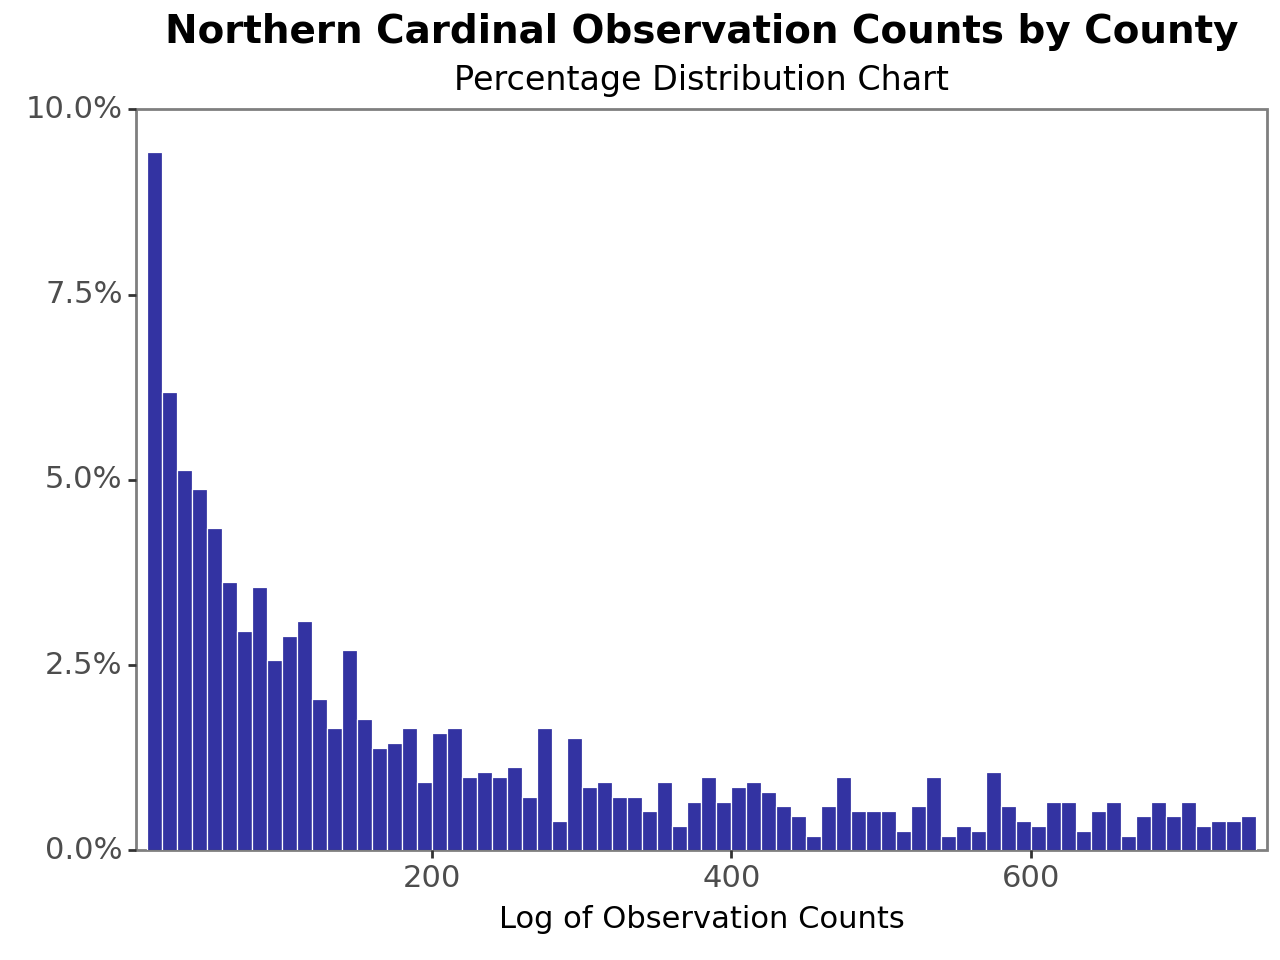


OBSERVATION COUNT DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.53, pvalue=0.00
Skewness: 3.62
Kurtosis: 15.22

_______________________________________________________________________________________________




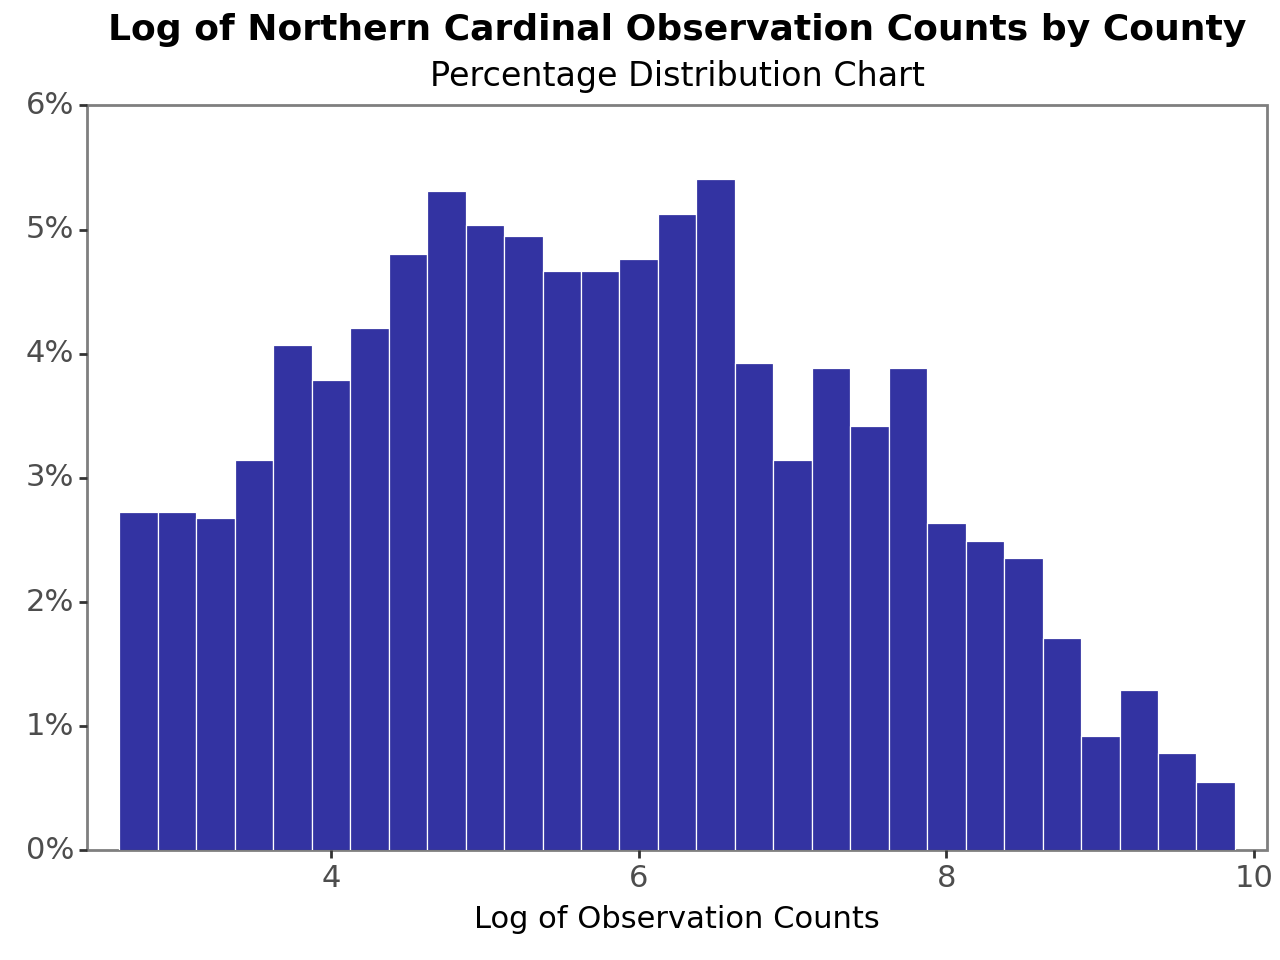


LOG OBSERVATION COUNT DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: 0.14
Kurtosis: -0.79


In [9]:
# we will start this part by creating a folder if it does not exist
# this folder will serve as the storage location for our plot pngs
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# non-transformed distribution chart
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="OBSERVATION_COUNT", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=10,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title='Northern Cardinal Observation Counts by County',
         subtitle = "Percentage Distribution Chart",
         x="Log of Observation Counts", 
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(10, 750)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.1) 

)


# log transformed distribution chart
plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_OBSERVATION_COUNT')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.25,  # Adjust the binwidth as needed
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title='Log of Northern Cardinal Observation Counts by County',
         subtitle = "Percentage Distribution Chart",
         x="Log of Observation Counts", 
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(2.5, 10)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=13, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.06) 
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_1.png")
plot1.save(file_path_1, width=10, height=8, dpi=300)
file_path_2 = os.path.join(folder_name, "dist_plot_2.png")
plot2.save(file_path_2, width=10, height=8, dpi=300)

# show the plots and statistics
print(plot1)
print("OBSERVATION COUNT DISTRIBUTION STATS\n" + "-"*46)
normality_test('OBSERVATION_COUNT')
print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG OBSERVATION COUNT DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_OBSERVATION_COUNT')

### **2.3.3** `DURATION_MINUTES` Distribution with Log Transformation Comparison
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_3.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_4.png


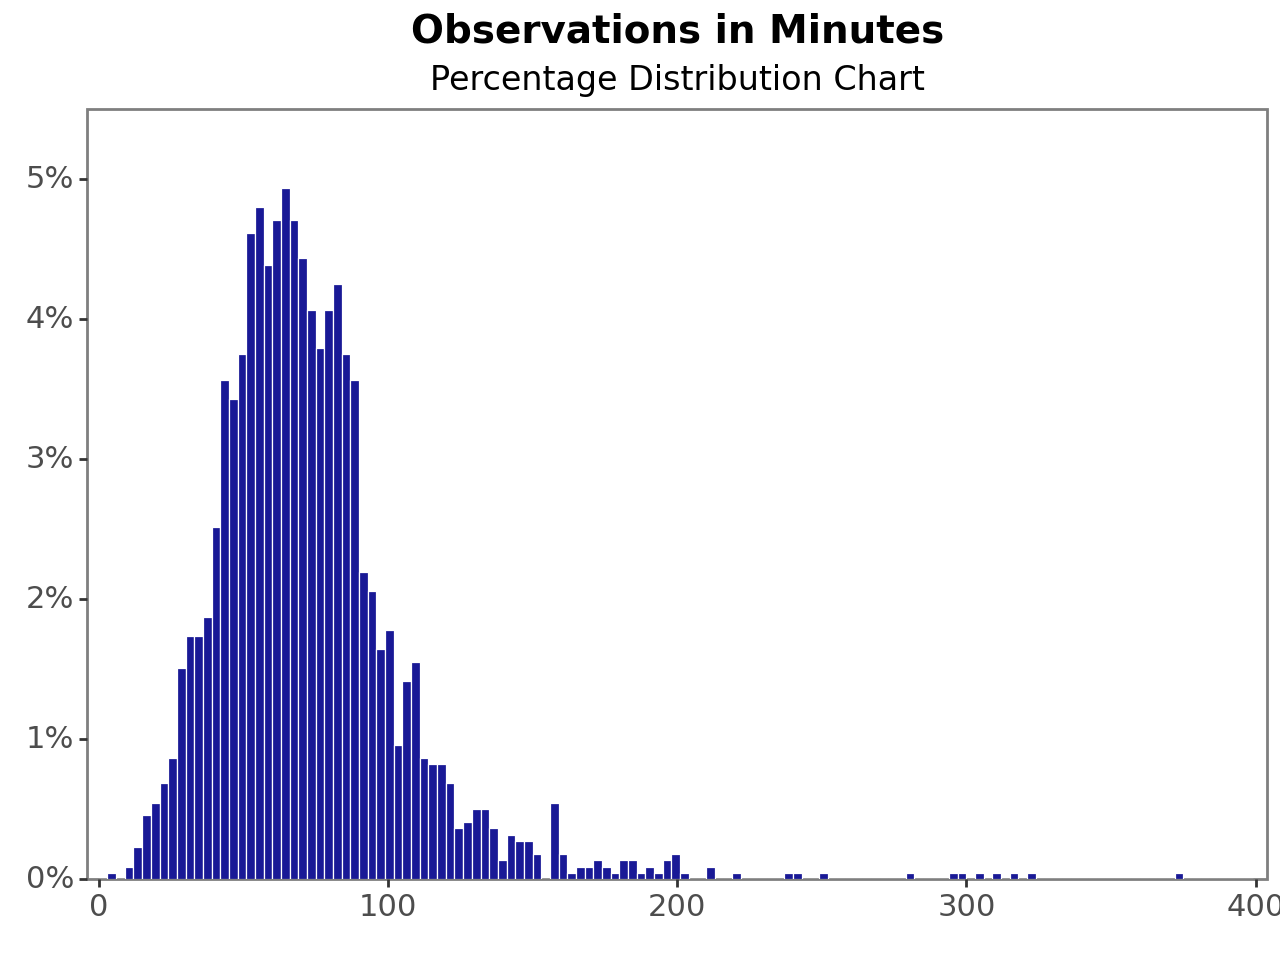


DURATION IN MINUTES DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.75, pvalue=0.00
Skewness: 4.2
Kurtosis: 40.31

_______________________________________________________________________________________________




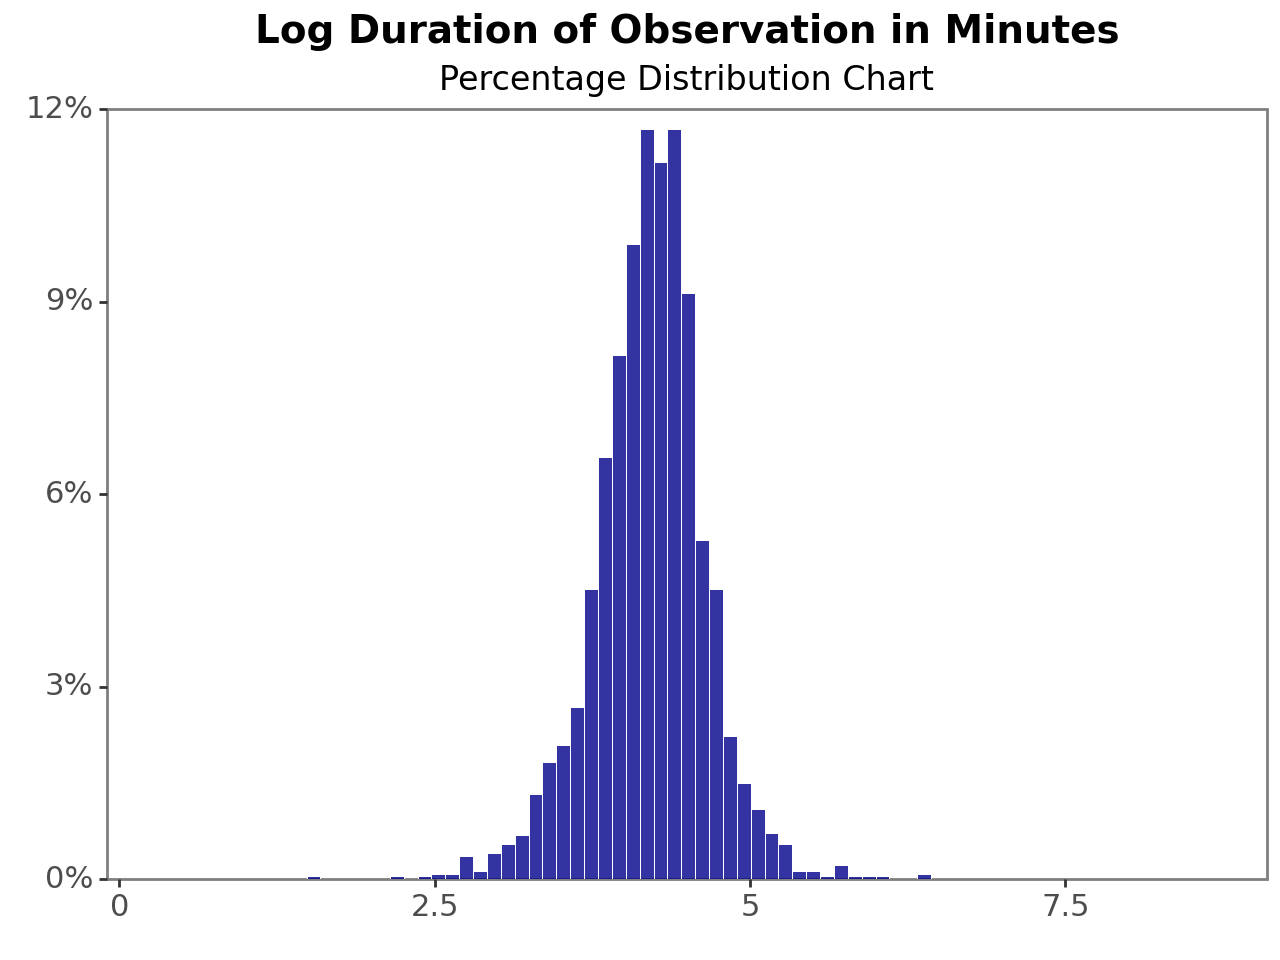


LOG OBSERVATIONS DURATION IN MINUTES DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: -0.23
Kurtosis: 2.25


In [10]:
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="DURATION_MINUTES", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.9,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title = "Observations in Minutes",
         subtitle = "Percentage Distribution Chart",
           x="",
           y=""
    ) +
    expand_limits(x=0.01, y=0.01) +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 400)) +
    scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.055),
        expand=(0.0, 0.0),
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    )
)



plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_DURATION_MINUTES')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.11,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Log Duration of Observation in Minutes",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 9)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.12)  # Ensure that the y-axis includes up to 12
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_3.png")
plot1.save(file_path_1, width=10, height=8, dpi=300)
file_path_2 = os.path.join(folder_name, "dist_plot_4.png")
plot2.save(file_path_2, width=10, height=8, dpi=300)



print(plot1)
print("DURATION IN MINUTES DISTRIBUTION STATS\n" + "-"*46)
normality_test('DURATION_MINUTES')
print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG OBSERVATIONS DURATION IN MINUTES DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_DURATION_MINUTES')

### **2.3.4** `EFFORT_DISTANCE` Distribution with Log Transformation Comparison
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_5.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_6.png


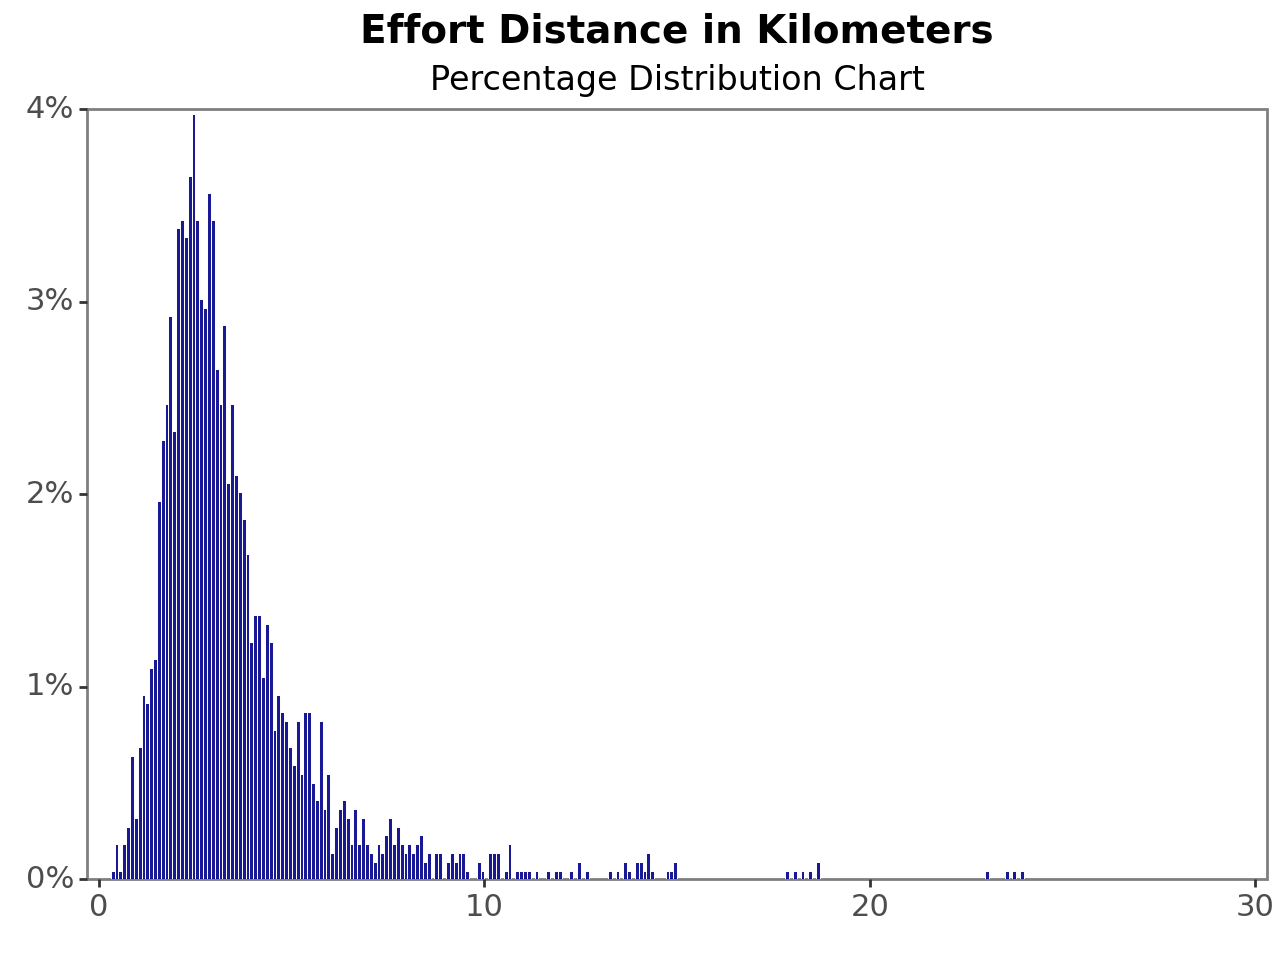


EFFORT DISTANCE IN KM DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.55, pvalue=0.00
Skewness: 9.84
Kurtosis: 207.87

_______________________________________________________________________________________________




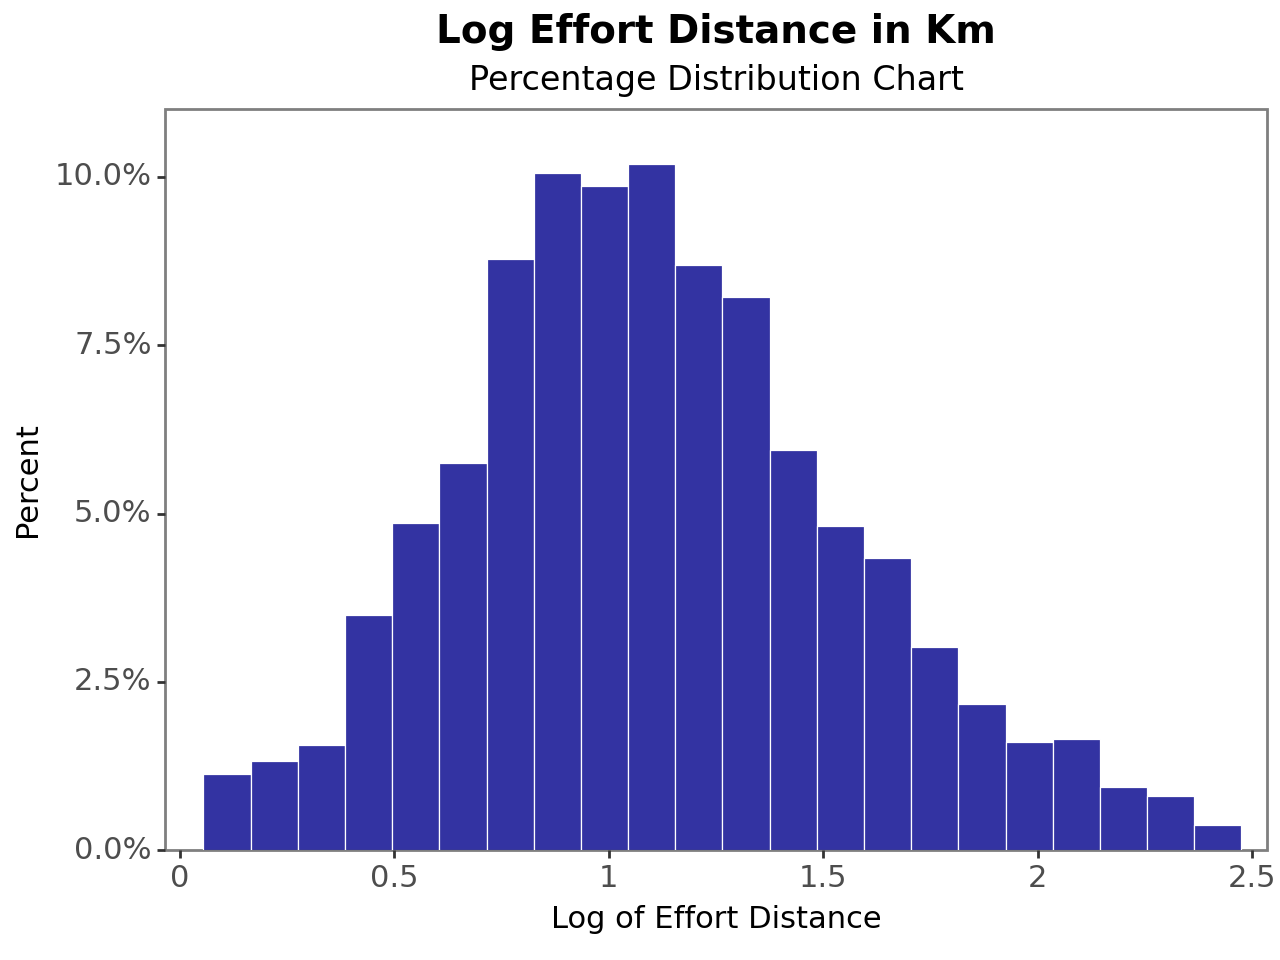


LOG EFFORT DISTANCE IN KM DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.98, pvalue=0.00
Skewness: 0.43
Kurtosis: 1.76


In [11]:
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="EFFORT_DISTANCE_KM", y="stat(count)/sum(stat(count))")) +
    geom_histogram(
        binwidth=.1, # cannot be higher than .1
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=.9,
        show_legend=False,
        na_rm=True,
    ) +
    labs(title = "Effort Distance in Kilometers",
         subtitle = "Percentage Distribution Chart",
           x="",
           y="") +
    expand_limits(x=0.01, y=0.01) +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30)) +
    scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.04),
        expand=(0.0, 0.0),
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    )
    
)

plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x='ln_EFFORT_DISTANCE_KM')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=0.11,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Log Effort Distance in Km",
         subtitle = "Percentage Distribution Chart",
         x="Log of Effort Distance", 
         y="Percent") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(0, 2.5)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(x=0.01, y=0.11) 
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_5.png")
plot1.save(file_path_1, width=10, height=8, dpi=300)
file_path_2 = os.path.join(folder_name, "dist_plot_6.png")
plot2.save(file_path_2, width=10, height=8, dpi=300)



print(plot1)
print("EFFORT DISTANCE IN KM DISTRIBUTION STATS\n" + "-"*46)
normality_test('EFFORT_DISTANCE_KM')

print("\n" + "_"*95 + "\n\n")
print(plot2)
print("LOG EFFORT DISTANCE IN KM DISTRIBUTION STATS\n" + "-"*46)
normality_test('ln_EFFORT_DISTANCE_KM')

### **2.3.5** `R_NATURAL_CHG_2022` Distribution 
---

A histogram was created for this visualization, along with the distribution statistics test. 

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_7.png


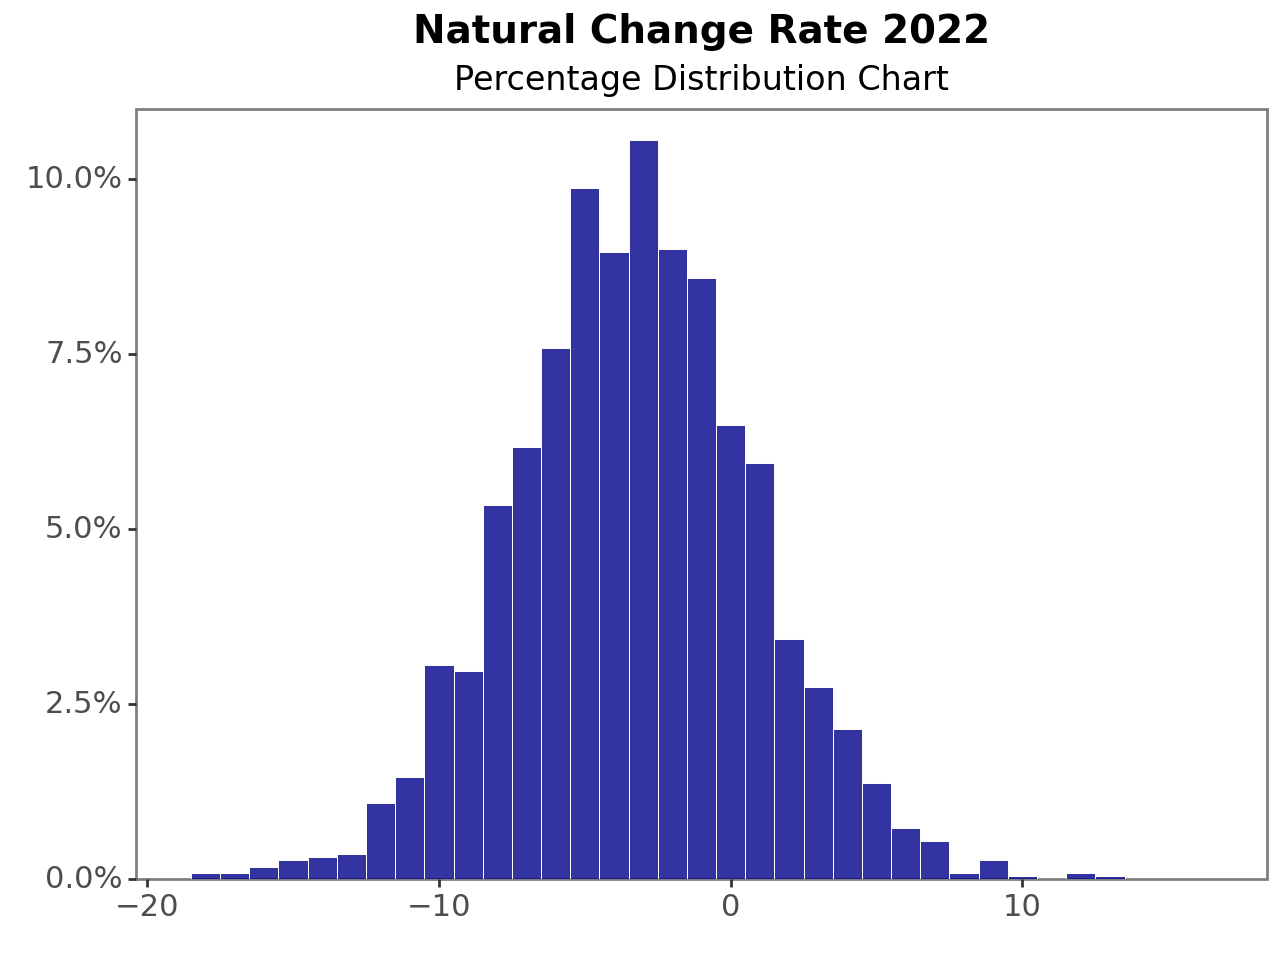


NATURAL CHANGE RATE 2022 DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.99, pvalue=0.00
Skewness: 0.04
Kurtosis: 1.17


In [12]:
plot = (
    ggplot(county_norcar_merged_dummies, aes(x='R_NATURAL_CHG_2022')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=1,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Natural Change Rate 2022",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(-20, 18)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.11)  # Ensure that the y-axis includes up to 12
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_7.png")
plot.save(file_path_1, width=10, height=8, dpi=300)



print(plot)
print("NATURAL CHANGE RATE 2022 DISTRIBUTION STATS\n" + "-"*46)
normality_test('R_NATURAL_CHG_2022')


### **2.3.6** `R_NET_MIG_2022` Distribution 
---

A histogram was created for this visualization, along with the distribution statistics test. 

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_8.png


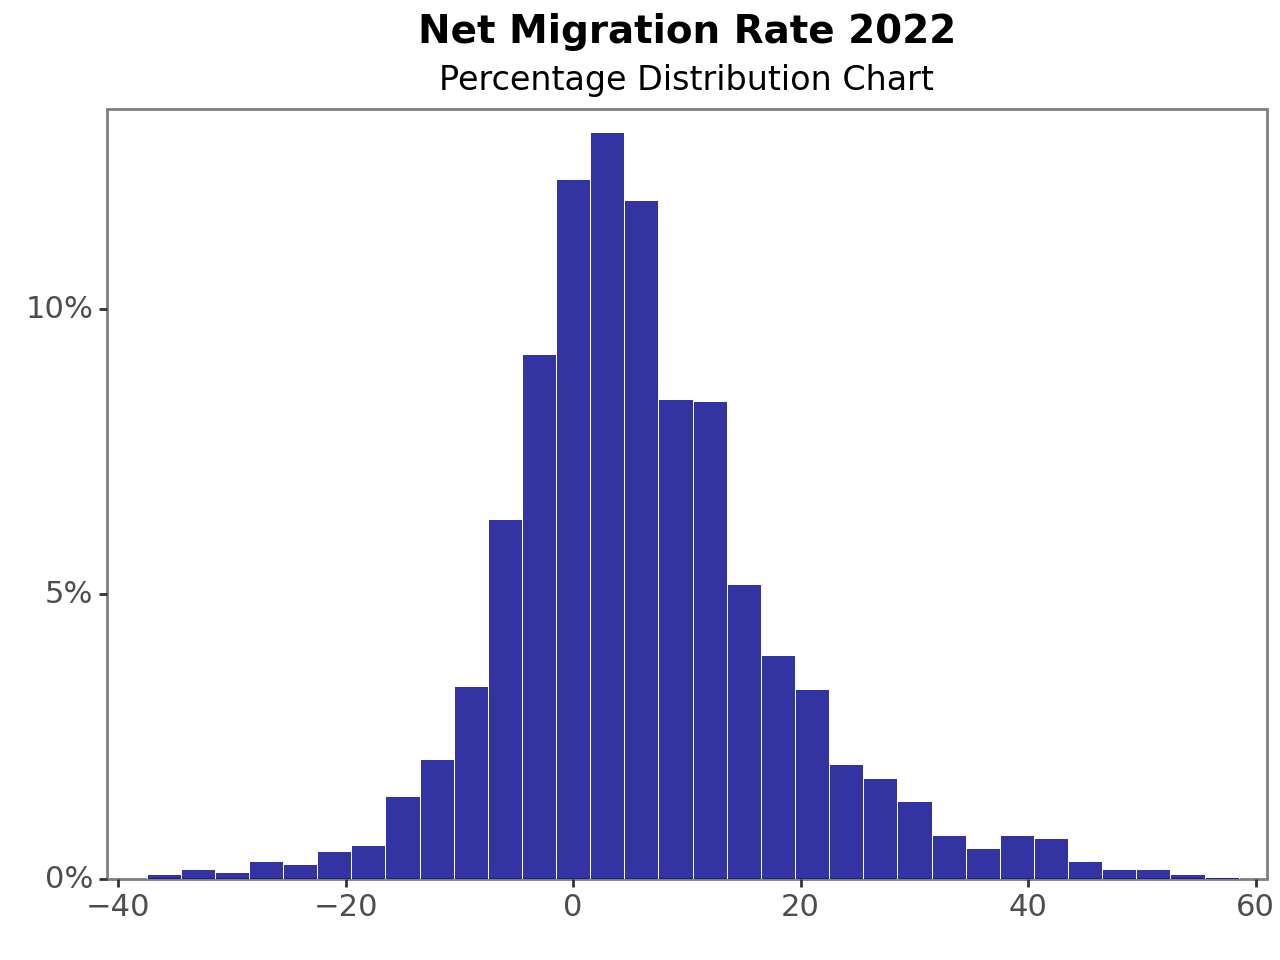


NET MIGRATION RATE 2022 DISTRIBUTION STATS
----------------------------------------------
Shapiro-Wilk Test: statistic=0.95, pvalue=0.00
Skewness: 0.79
Kurtosis: 3.07


In [13]:
plot = (
    ggplot(county_norcar_merged_dummies, aes(x='R_NET_MIG_2022')) +
    geom_histogram(
        aes(y='stat(count)/sum(stat(count))'),
        binwidth=3,  # Adjust the binwidth as needed
        color="white",
        fill = "darkblue",
        size=0.2,
        alpha=0.8,
        show_legend=False,
        na_rm=True
    ) +
    labs(title = "Net Migration Rate 2022",
         subtitle = "Percentage Distribution Chart",
         x="",
         y="") +
    scale_x_continuous(expand=(0.01, 0.01), limits=(-40, 60)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0)) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
    ) +
    expand_limits(y=0.135)  # Ensure that the y-axis includes up to 12
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_8.png")
plot.save(file_path_1, width=10, height=8, dpi=300)


print(plot)
print("NET MIGRATION RATE 2022 DISTRIBUTION STATS\n" + "-"*46)
normality_test('R_NET_MIG_2022')


### **2.3.7** `Urban_Influence_2013` County Percentage Distribution 
---

A barchart was created for this county percentage distribution. 

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_9.png


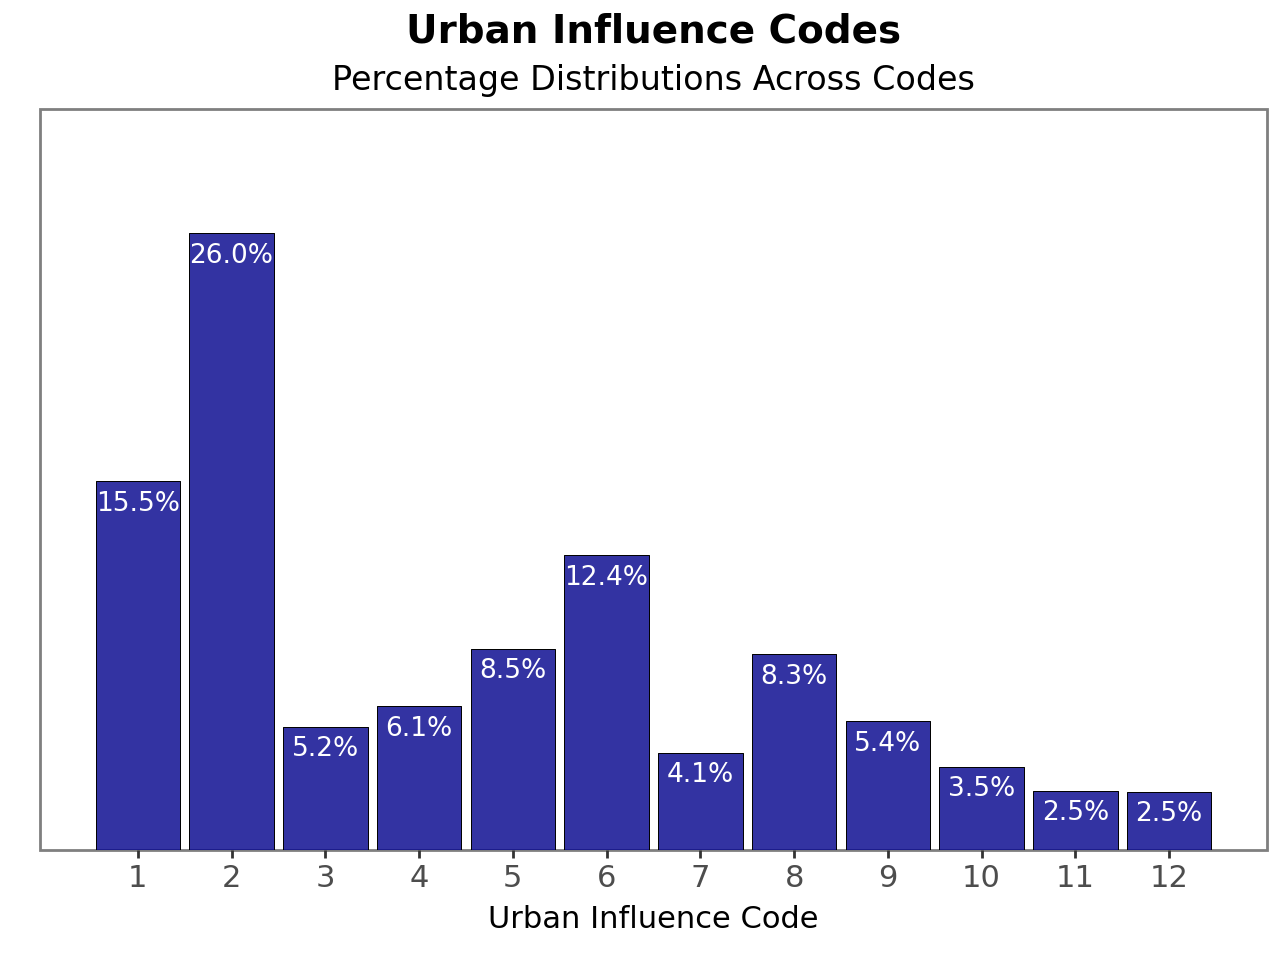

In [14]:
counts = county_norcar_merged_dummies['Urban_Influence_2013'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Urban_Influence_2013': 'Urban_Influence_2013', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Urban_Influence_2013', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.015,
        va='bottom',
        size=9.5,
        color='white',
        format_string='{}%'
    ) +
    labs(title='Urban Influence Codes',
         subtitle = "Percentage Distributions Across Codes",
         x='Urban Influence Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_9.png")
plot.save(file_path_1, width=10, height=8, dpi=300)


print(plot)


### **2.3.8** `Rural_Urban_Continuum_Code_2013` County Percentage Distribution 
---

A barchart was created for this county percentage distribution. 

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_10.png


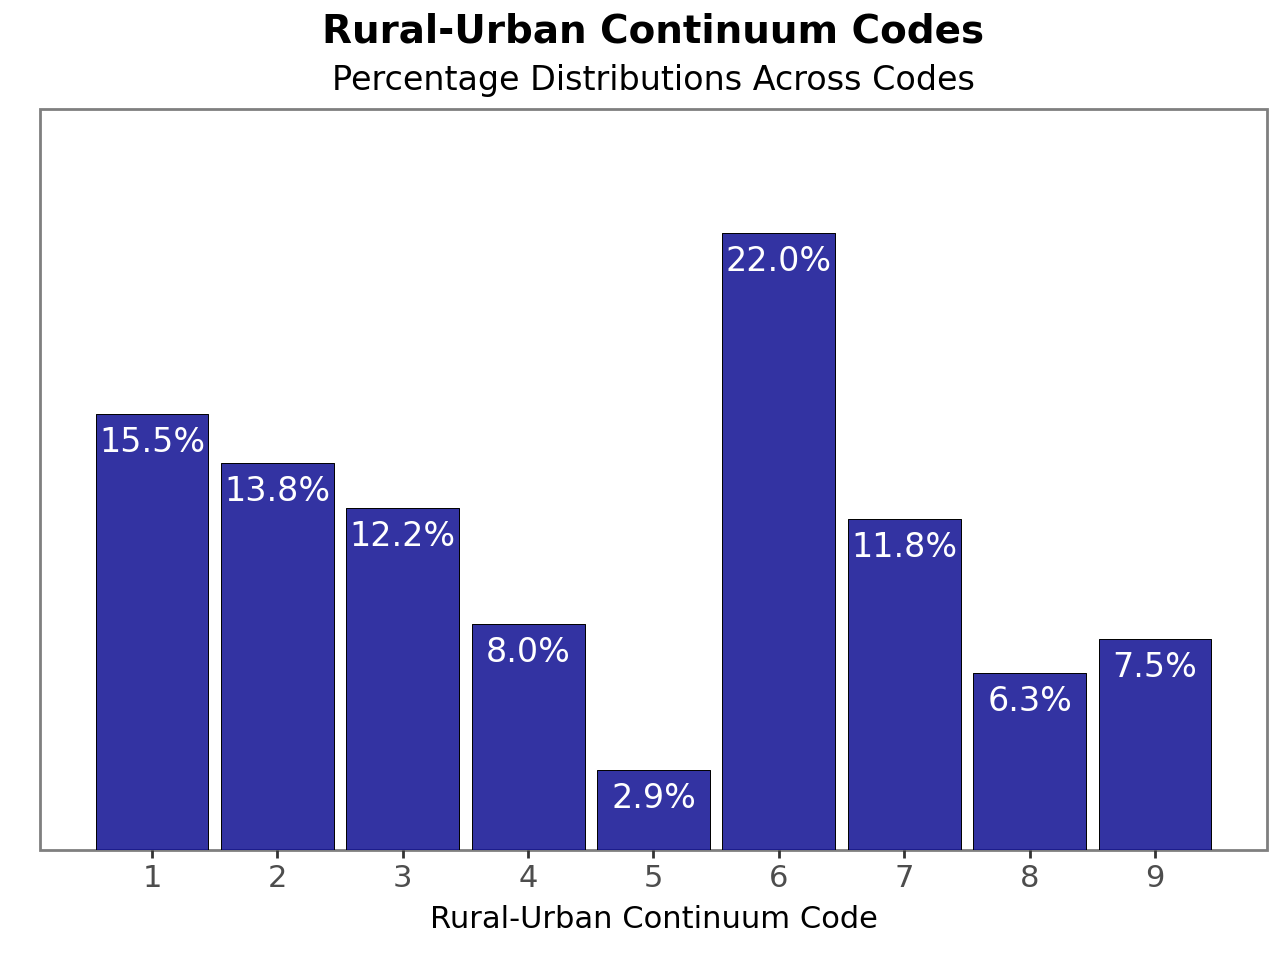

In [15]:
counts = county_norcar_merged_dummies['Rural_Urban_Continuum_Code_2013'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Rural_Urban_Continuum_Code_2013': 'Rural_Urban_Continuum_Code_2013', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Rural_Urban_Continuum_Code_2013', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.016,
        va='bottom',
        size=12,
        color='white',
        format_string='{}%'
    ) +
    labs(title='Rural-Urban Continuum Codes',
         subtitle = "Percentage Distributions Across Codes",
         x='Rural-Urban Continuum Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_10.png")
plot.save(file_path_1, width=10, height=8, dpi=300)

print(plot)


### **2.3.9** `Economic_typology_2015` County Percentage Distribution 
---

A barchart was created for this county percentage distribution. 

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\dist_plot_11.png


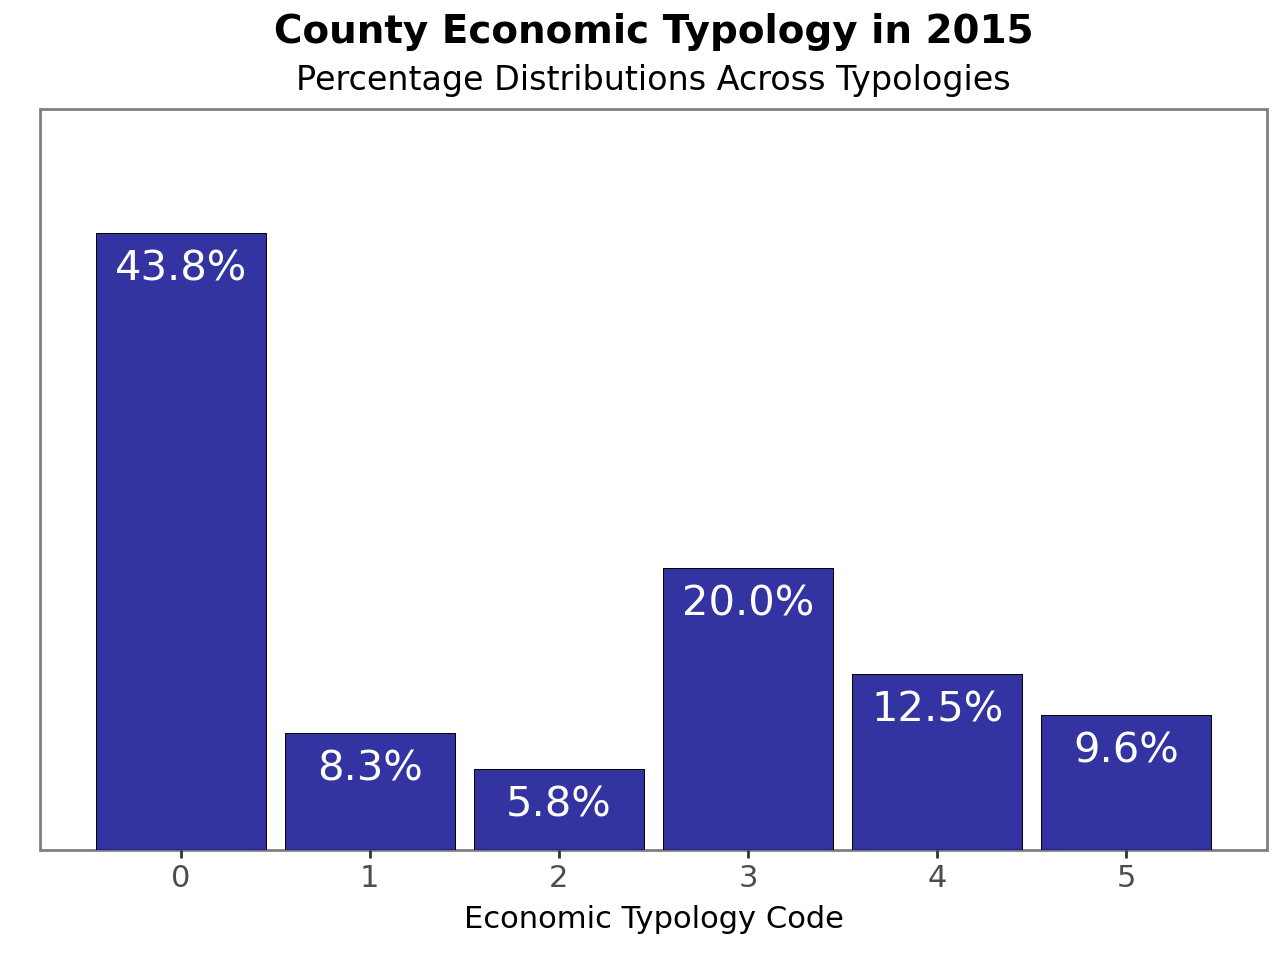


County Economic Code Descriptions
0: non-specified
1: Farm Dependent
2: Mining Dependent
3: Manufacturing Dependent
4: Federal/State Government Dependent
5: Recreation Dependent


In [16]:
counts = county_norcar_merged_dummies['Economic_typology_2015'].value_counts(normalize=True) # Get the percentage of each category
counts_df = counts.reset_index().rename(columns={'index': 'index', 'Economic_typology_2015': 'Economic_typology_2015', 'proportion':'Percentage'})

plot = (
    ggplot(counts_df, aes(x='Economic_typology_2015', y='Percentage')) +
    geom_bar(stat='identity', fill='darkblue', color='black', size=0.2, alpha=0.8) +
    geom_text(
        aes(label='round(Percentage * 100, 1)'),  # Round the percentage to 1 decimal places
        stat='identity',
        nudge_y=-.04,
        va='bottom',
        size=15,
        color='white',
        format_string='{}%'
    ) +
    labs(title='County Economic Typology in 2015',
         subtitle = "Percentage Distributions Across Typologies",
         x='Economic Typology Code',
         y='') +
    theme_bw() +
    scale_x_continuous(breaks=range(0, 6)) +
    scale_y_continuous(labels=percent_format(), expand=(0.0, 0.0), limits=(0, 1.2 * max(counts_df['Percentage']))) +  # Expand y-axis range
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5), # Centered Subtitle
        axis_text=element_text(size=11),
        axis_text_y=element_blank(),  # Remove y-axis labels
        axis_ticks_major_y=element_blank(),  # Remove y-axis ticks
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks_minor=element_blank()
    )
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "dist_plot_11.png")
plot.save(file_path_1, width=10, height=8, dpi=300)


print(plot)
print("County Economic Code Descriptions\n0: non-specified\n1: Farm Dependent\n2: Mining Dependent\n3: Manufacturing Dependent\n4: Federal/State Government Dependent\n5: Recreation Dependent")

# **3.** Regression Analyses and Predictive Models
---

There were four sets of regression models run to test the association between urban development and populations on the log of Northern Cardinal observations. As the first three variables were categorical variables, they were run separately in groups of binary variables to avoid multicollinearity and overfitting by too many variables. A Variance Inflation Factor (VIF) test was run for each set of variables to identify potential multicollinearity, of which, none was found.

---

## **3.1** OLS Regression Models of `Urban_Influence_2013` on `ln_OBSERVATION_COUNT`
---

In this research, two distinct sets of Ordinary Least Squares (OLS) models were executed to examine the association of Rural-Urban Continuum Codes and Urban Influence Codes on the log counts of Northern Cardinal observations. The selection of the OLS methodology was based on the hypothesized linear association between the urban development status and the log of Northern Cardinal observation frequencies. Given that both Rural-Urban Continuum and Urban Influence Codes provide analogous insights regarding a county's characteristics, they were analysed independently to corroborate and enhance the robustness of the findings. In each set of models, the initial code (Code 1 for both sets) was the reference category and excluded from the regression analysis. Subsequently, a series of OLS regressions were conducted for each code set, progressively incorporating additional code variables as explanatory factors (Rural-Urban Continuum Codes 2 through 9 and Urban Influence Codes 2 through 12, respectively). To account for potential heteroscedasticity, all models were estimated using heteroscedasticity-consistent standard errors of type HC1.

The analysis of both model sets yielded similar outcomes. In each case, the comprehensive model, including all codes except the benchmark (code 1), demonstrated superior model efficacy, as evidenced by the highest R-Squared value. These models were selected for the analysis. The R-Squared for the Urban Influence Code OLS regression was determined to be 32.5%, while 34.1% for the Rural-Urban Continuum Code OLS regression. This indicates that approximately 33% of the variation in log observation counts is explainable by each model.

A consistent pattern emerged across both the Rural-Urban Continuum Codes and Urban Influence Codes. All codes exhibited statistically significant correlation coefficients at the 1% significance level. This uniform significance is likely due to the substantial data volume. Notably, in each model, the correlation coefficients increasingly deviated from zero in a negative trajectory. This trend suggests a positive relationship between the urbanization codes and the log of observation counts, which is observed in both the Rural-Urban Continuum Codes (Codes 2-9) and Urban Influence Codes (Codes 2-12). Therefore, the data provides evidence in support of a positive association between both Rural-Urban Continuum Codes and Urban Influence Codes, and the log of Northern Cardinal observations in US counties.

*Note*: As the Urban Influence and Rural-Urban Continuum Codes are similar, this explanation and interpretation applies to both 3.1 and 3.2 regression models.

---

### **3.1.1** OLS Regression Models 1-11
---

In [17]:
# Variance Inflation Factor test to determine if multicolinearity is prevalent amongst the variables being testing in the model
# Add a constant to the DataFrame for the intercept
df_with_constant = add_constant(county_norcar_merged_dummies[['UrbanInfluence_2', 'UrbanInfluence_3', 'UrbanInfluence_4', 
                                   'UrbanInfluence_5', 'UrbanInfluence_6', 'UrbanInfluence_7', 
                                   'UrbanInfluence_8', 'UrbanInfluence_9', 'UrbanInfluence_10', 
                                   'UrbanInfluence_11', 'UrbanInfluence_12']])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = df_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) 
                   for i in range(df_with_constant.shape[1])]

print("Variance Inflation Factor test for identifying multicollinearity amongst variables")
print("-"*40)
print(vif_data)

Variance Inflation Factor test for identifying multicollinearity amongst variables
----------------------------------------
             Variable       VIF
0               const  6.441176
1    UrbanInfluence_2  1.978900
2    UrbanInfluence_3  1.265786
3    UrbanInfluence_4  1.306689
4    UrbanInfluence_5  1.415665
5    UrbanInfluence_6  1.576438
6    UrbanInfluence_7  1.212732
7    UrbanInfluence_8  1.405706
8    UrbanInfluence_9  1.276644
9   UrbanInfluence_10  1.183348
10  UrbanInfluence_11  1.132588
11  UrbanInfluence_12  1.130250


In [18]:
# OLS on Urban Influence Codes
reg1 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2", data=county_norcar_merged_dummies).fit(cov_type="HC1") #unconditional
reg2 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg3 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg4 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg5 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg6 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg7 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg8 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg9 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg10 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10 + UrbanInfluence_11", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg11 = smf.ols(formula="ln_OBSERVATION_COUNT ~ UrbanInfluence_2 + UrbanInfluence_3 + UrbanInfluence_4 + UrbanInfluence_5 + UrbanInfluence_6 + UrbanInfluence_7 + UrbanInfluence_8 + UrbanInfluence_9 + UrbanInfluence_10 + UrbanInfluence_11 + UrbanInfluence_12", data=county_norcar_merged_dummies).fit(cov_type="HC1")

stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10, reg11])
stargazer.covariate_order(["UrbanInfluence_2", "UrbanInfluence_3", "UrbanInfluence_4", 
                           "UrbanInfluence_5", "UrbanInfluence_6", "UrbanInfluence_7", 
                           "UrbanInfluence_8", "UrbanInfluence_9", "UrbanInfluence_10",
                           "UrbanInfluence_11", "UrbanInfluence_12", "Intercept"])

stargazer.rename_covariates({
    "UrbanInfluence_2": "Urban Influence Code 2",
    "UrbanInfluence_3": "Urban Influence Code 3",
    "UrbanInfluence_4": "Urban Influence Code 4",
    "UrbanInfluence_5": "Urban Influence Code 5",
    "UrbanInfluence_6": "Urban Influence Code 6",
    "UrbanInfluence_7": "Urban Influence Code 7",
    "UrbanInfluence_8": "Urban Influence Code 8",
    "UrbanInfluence_9": "Urban Influence Code 9",
    "UrbanInfluence_10": "Urban Influence Code 10",
    "UrbanInfluence_11": "Urban Influence Code 11",
    "UrbanInfluence_12": "Urban Influence Code 12",
    "Intercept": "Constant"
})

stargazer.custom_columns(["Reg 1", "Reg 2", "Reg 3", "Reg 4", "Reg 5", "Reg 6", "Reg 7", "Reg 8", "Reg 9", "Reg 10", "Reg 11"], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

stargazer

### **3.1.2** Predictive Model from the OLS Regression of `Urban_Influence_2013` on `ln_OBSERVATION_COUNT`
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_1.png


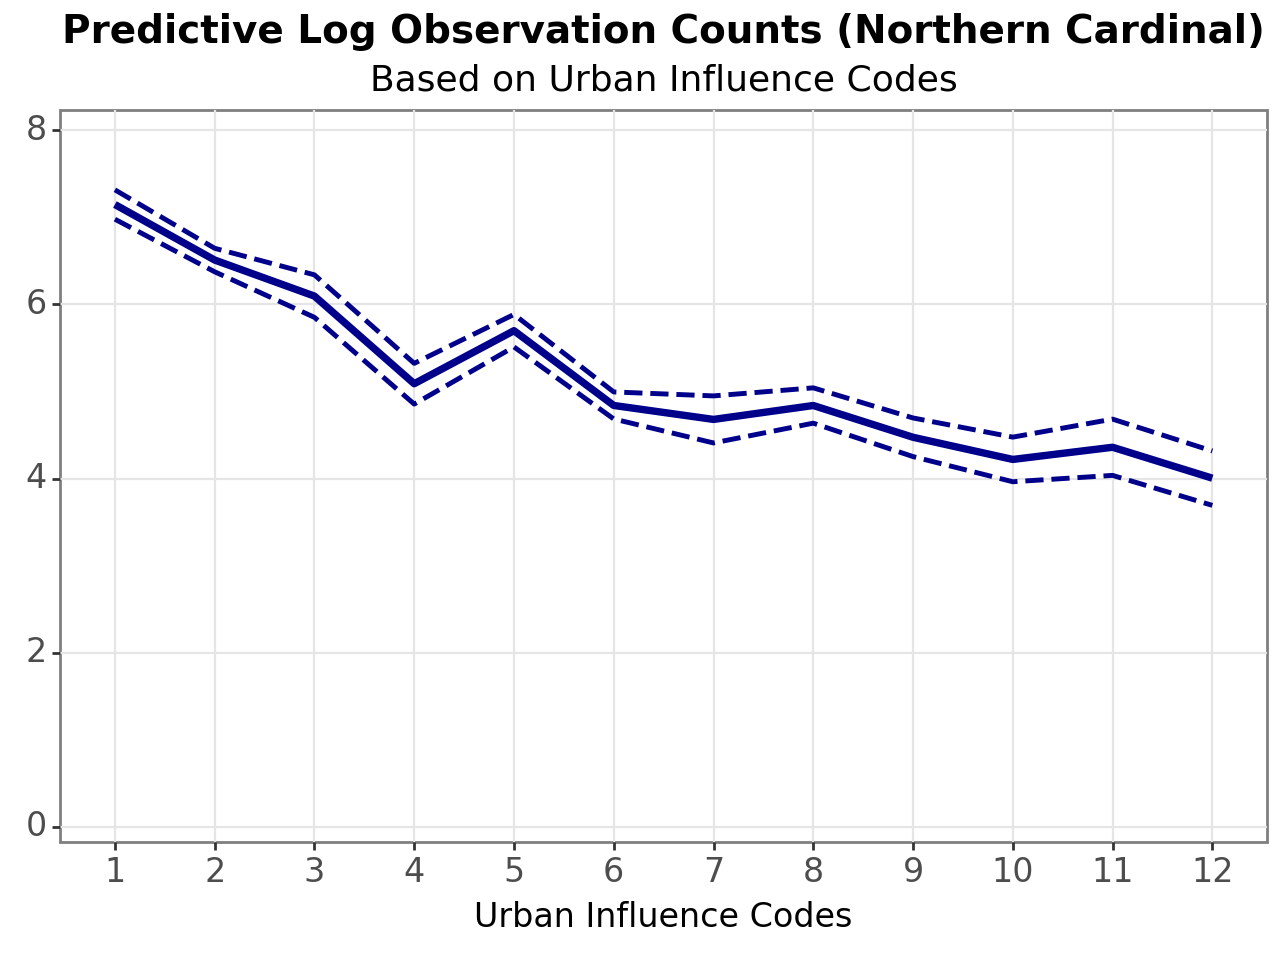

In [19]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg11.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Urban_Influence_2013", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Urban Influence Codes",
        x="Urban Influence Codes",
        y="" # no y-axis title as it is in the title
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Center bold title, size 14
        plot_subtitle=element_text(size=13, hjust=0.5), # Center subtitle, size 13
        axis_title=element_text(size=12), # Axis titles size 12
        axis_text_x=element_text(size=12), # X-axis text size 12
        axis_text_y=element_text(size=12), # Y-axis text size 12
        legend_position="bottom", # Position legend at bottom
        panel_grid_minor=element_blank(), # Remove minor grid lines
    ) +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    )
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "pred_plot_1.png")
plot.save(file_path_1, width=10, height=8, dpi=300)

print(plot)


## **3.2** OLS Regression Models of `Rural_Urban_Continuum_Code_2013` on `ln_OBSERVATION_COUNT`
---

### **3.2.1** OLS Regression Models 12-19
---

In [20]:
# Variance Inflation Factor test to determine if multicolinearity is prevalent amongst the variables being testing in the model
# Add a constant to the DataFrame for the intercept
df_with_constant = add_constant(county_norcar_merged_dummies[['Continuum_2', 'Continuum_3', 'Continuum_4', 
                                   'Continuum_5', 'Continuum_6', 'Continuum_7', 
                                   'Continuum_8', 'Continuum_9']])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = df_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) 
                   for i in range(df_with_constant.shape[1])]

print("Variance Inflation Factor test for identifying multicollinearity amongst variables")
print("-"*40)
print(vif_data)

Variance Inflation Factor test for identifying multicollinearity amongst variables
----------------------------------------
      Variable       VIF
0        const  6.441176
1  Continuum_2  1.627849
2  Continuum_3  1.567635
3  Continuum_4  1.395681
4  Continuum_5  1.151197
5  Continuum_6  1.884353
6  Continuum_7  1.551620
7  Continuum_8  1.317293
8  Continuum_9  1.373388


In [21]:
# OLS on Rural-Urban Continuum Codes
reg12 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2", data=county_norcar_merged_dummies).fit(cov_type="HC1") # Unconditional
reg13 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg14 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg15 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg16 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg17 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg18 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7 + Continuum_8", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg19 = smf.ols(formula="ln_OBSERVATION_COUNT ~ Continuum_2 + Continuum_3 + Continuum_4 + Continuum_5 + Continuum_6 + Continuum_7 + Continuum_8 + Continuum_9", data=county_norcar_merged_dummies).fit(cov_type="HC1")

stargazer = Stargazer([reg12, reg13, reg14, reg15, reg16, reg17, reg18, reg19])
stargazer.covariate_order(["Continuum_2", "Continuum_3", "Continuum_4", 
                           "Continuum_5", "Continuum_6", "Continuum_7", 
                           "Continuum_8", "Continuum_9", "Intercept"])

stargazer.rename_covariates({
    "Continuum_2": "Rural-Urban Continuum Code 2",
    "Continuum_3": "Rural-Urban Continuum Code 3",
    "Continuum_4": "Rural-Urban Continuum Code 4",
    "Continuum_5": "Rural-Urban Continuum Code 5",
    "Continuum_6": "Rural-Urban Continuum Code 6",
    "Continuum_7": "Rural-Urban Continuum Code 7",
    "Continuum_8": "Rural-Urban Continuum Code 8",
    "Continuum_9": "Rural-Urban Continuum Code 9",
    "Intercept": "Constant"
})

stargazer.custom_columns(["Reg 12", "Reg 13", "Reg 14", "Reg 15", "Reg 16", "Reg 17", "Reg 18", "Reg 19"], [1, 1, 1, 1, 1, 1, 1, 1])

stargazer

### **3.2.2** Predictive Model from the OLS Regression of `Rural_Urban_Continuum_Code_2013` on `ln_OBSERVATION_COUNT`
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_2.png


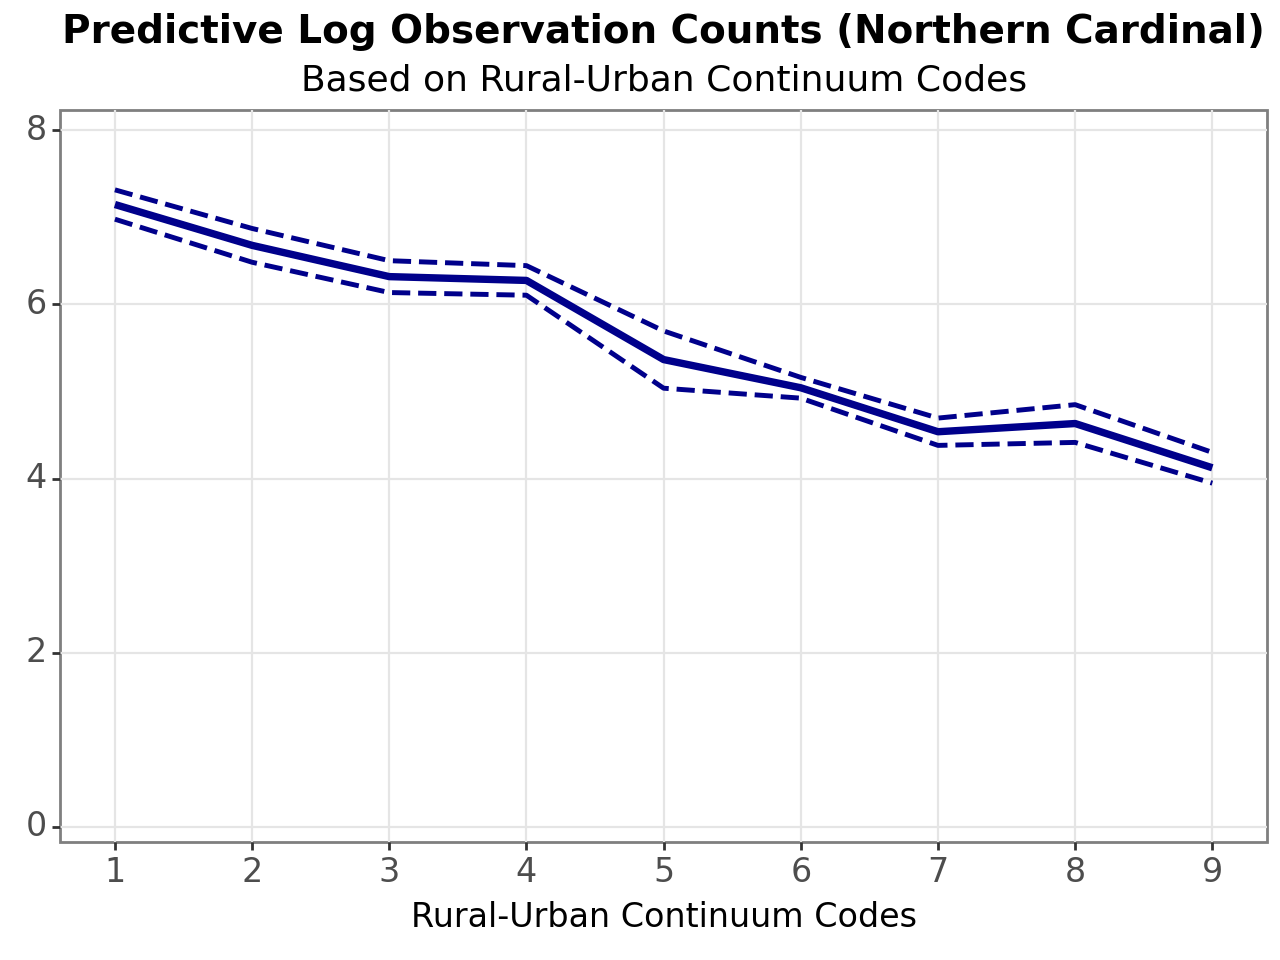

In [22]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg19.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Rural_Urban_Continuum_Code_2013", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Rural-Urban Continuum Codes",
        x="Rural-Urban Continuum Codes",
        y=""
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Center bold title, size 14
        plot_subtitle=element_text(size=13, hjust=0.5), # Center subtitle, size 13
        axis_title=element_text(size=12), # Axis titles size 12
        axis_text_x=element_text(size=12), # X-axis text size 12
        axis_text_y=element_text(size=12), # Y-axis text size 12
        legend_position="bottom", # Position legend at bottom
        panel_grid_minor=element_blank(), # Remove minor grid lines
    ) +
    scale_x_continuous(breaks=range(1, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    )
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "pred_plot_2.png")
plot.save(file_path_1, width=10, height=8, dpi=300)

print(plot)


## **3.3** OLS Regression Models of `Economic_typology_2015` on `ln_OBSERVATION_COUNT`
---

OLS models were executed to examine the association between County Typology Codes and the log of Northern Cardinal observations. The OLS model was selected due to the hypothesized linear association between the urban development status and the log of Northern Cardinal observation frequencies. Economic typology represents the urban development status of a county from a different. In the model, the code 0 (non-specialized counties) was designated as the reference category and excluded from the regression analysis. A series of OLS regressions were conducted for each typology code, progressively incorporating additional code variables as explanatory factors (Code 1: Economically Farming Dependent, etc.). To account for potential heteroscedasticity, all models were estimated using heteroscedasticity-consistent standard errors of type HC1.

The analysis revealed that the regression model with all economic types was the best fit, with an R-Squared suggesting that 11.8% of the variance in log observation counts is explained by this model. Farming, mining, and manufacturing dependent resulted in statistically significant negative coefficients at the 1% threshold, while government dependent and recreation dependent were not statistically significant. This would suggest that farming, mining, or manufacturing dependent counties are associated with less Northern Cardinal observation counts. 


---

### **3.3.1** OLS Regression Models 20-24
---

In [23]:
# Variance Inflation Factor test to determine if multicolinearity is prevalent amongst the variables being testing in the model
# Add a constant to the DataFrame for the intercept
df_with_constant = add_constant(county_norcar_merged_dummies[['EconType_FarmDependent', 'EconType_MiningDependent', 'EconType_ManufacturingDependent', 
                                   'EconType_FederalStateGovDependent', 'EconType_RecreationDependent']])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = df_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) 
                   for i in range(df_with_constant.shape[1])]

print("Variance Inflation Factor test for identifying multicollinearity amongst variables")
print("-"*40)
print(vif_data)

Variance Inflation Factor test for identifying multicollinearity amongst variables
----------------------------------------
                            Variable       VIF
0                              const  2.283629
1             EconType_FarmDependent  1.090904
2           EconType_MiningDependent  1.066293
3    EconType_ManufacturingDependent  1.165549
4  EconType_FederalStateGovDependent  1.124853
5       EconType_RecreationDependent  1.102090


In [24]:
# OLS on Rural-Urban Continuum Codes
reg20 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1") # Unconditional
reg21 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg22 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg23 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent + EconType_FederalStateGovDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg24 = smf.ols(formula="ln_OBSERVATION_COUNT ~ EconType_FarmDependent + EconType_MiningDependent + EconType_ManufacturingDependent + EconType_FederalStateGovDependent + EconType_RecreationDependent", data=county_norcar_merged_dummies).fit(cov_type="HC1")


stargazer = Stargazer([reg20, reg21, reg22, reg23, reg24])
stargazer.covariate_order(["EconType_FarmDependent", "EconType_MiningDependent", "EconType_ManufacturingDependent", 
                           "EconType_FederalStateGovDependent", "EconType_RecreationDependent", "Intercept"])

stargazer.rename_covariates({
    "EconType_FarmDependent": "Economically Farming Dependent",
    "EconType_MiningDependent": "Economically Mining Dependent",
    "EconType_ManufacturingDependent": "Economically Manufacturing Dependent",
    "EconType_FederalStateGovDependent": "Economically Federal/State Government Dependent",
    "EconType_RecreationDependent": "Economically Recreation Dependent",
    "Intercept": "Constant"
})

stargazer.custom_columns(["Reg 20", "Reg 21", "Reg 22", "Reg 23", "Reg 24"], [1, 1, 1, 1, 1])

stargazer

### **3.3.2** Predictive Model from the OLS Regression of `Economic_typology_2015` on `ln_OBSERVATION_COUNT`
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_3.png


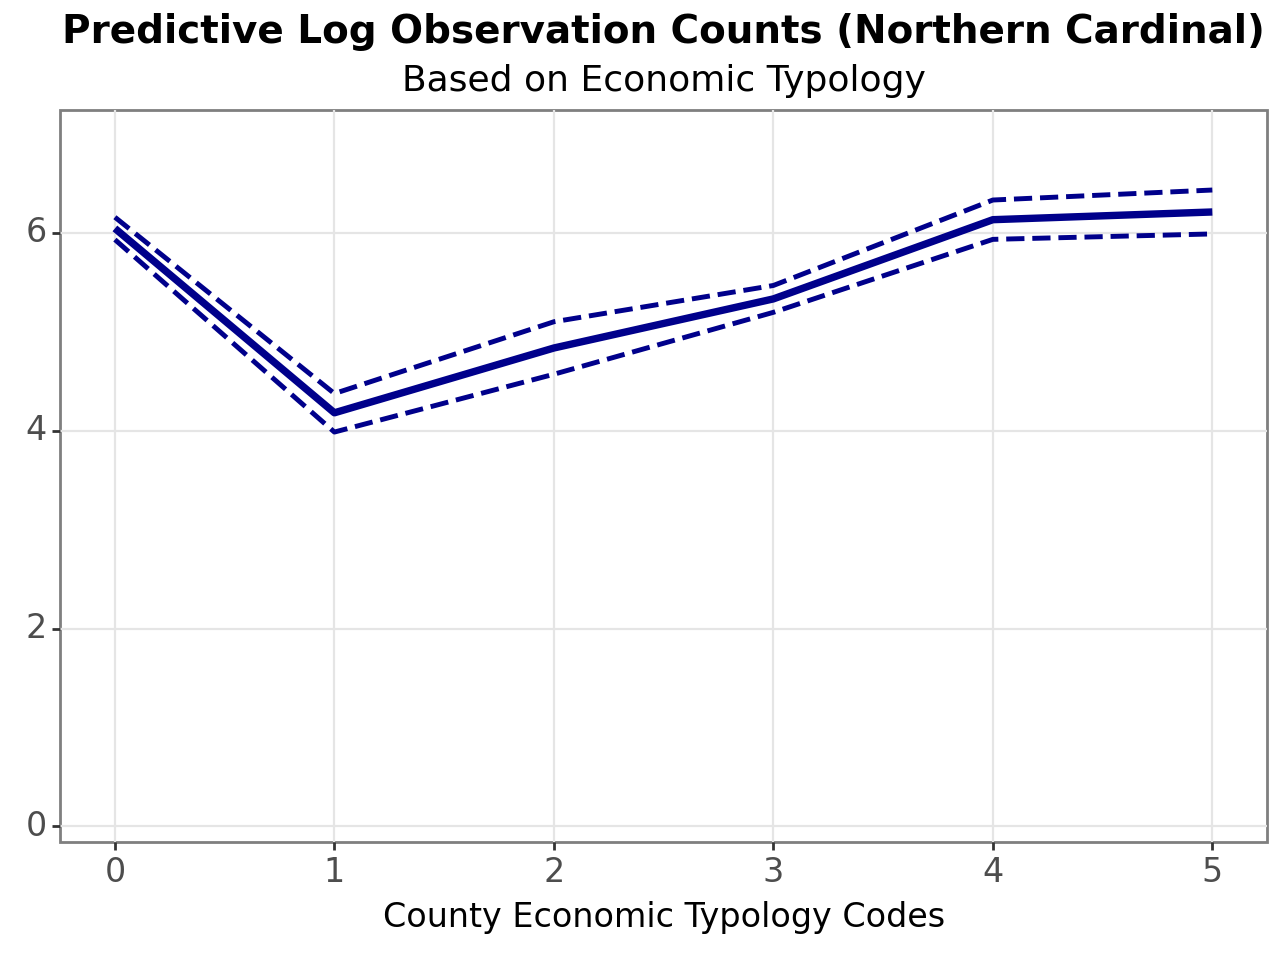


County Economic Code Descriptions
0: non-specified
1: Farm Dependent
2: Mining Dependent
3: Manufacturing Dependent
4: Federal/State Government Dependent
5: Recreation Dependent


In [25]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg24.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals

plot = (
    ggplot(county_norcar_merged_dummies, aes(x="Economic_typology_2015", y="fit")) +
    geom_line(color="darkblue", size=1.5) +  # Main line for fit values
    geom_line(aes(y="CIup"), linetype="dashed", color="darkblue", size=1) +  # Upper confidence interval
    geom_line(aes(y="CIlo"), linetype="dashed", color="darkblue", size=1) +  # Lower confidence interval
    labs(
        title="Predictive Log Observation Counts (Northern Cardinal)",
        subtitle="Based on Economic Typology",
        x="County Economic Typology Codes",
        y="" # removed y-axis title because it can be found in the title
    ) +
    theme_bw() +
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Center bold title, size 14
        plot_subtitle=element_text(size=13, hjust=0.5), # Center subtitle, size 13
        axis_title=element_text(size=12), # Axis titles size 12
        axis_text_x=element_text(size=12), # X-axis text size 12
        axis_text_y=element_text(size=12), # Y-axis text size 12
        legend_position="bottom", # Position legend at bottom
        panel_grid_minor=element_blank(), # Remove minor grid lines
    ) +
    scale_x_continuous(breaks=range(0, 13)) +
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].max() * 1.1),  # Add a 10% buffer to the max limit for visual appeal
        expand=(0.02, 0.02)  # Small expansion factor for padding
    ) +
    guides(color=guide_legend(title="Legend"))  # Add and customize legend
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "pred_plot_3.png")
plot.save(file_path_1, width=10, height=8, dpi=300)

print(plot)
print("County Economic Code Descriptions\n0: non-specified\n1: Farm Dependent\n2: Mining Dependent\n3: Manufacturing Dependent\n4: Federal/State Government Dependent\n5: Recreation Dependent")

## **3.4** OLS Regression Models For `R_NATURAL_CHG_2022`, `R_NET_MIG_2022`, `ln_DURATION_MINUTES`, and `ln_EFFORT_DISTANCE_KM` on `ln_OBSERVATION_COUNT`
---

The final OLS models examined the associations between population changes and observation methods, with Northern Cardinal observation counts. These models incorporated natural change and net immigration rates per county to explore how population dynamics relate to observation counts. Additionally, the log-transformed variables for duration and distance of observations were included to examine potential associations with observation counts. The chosen model accounted for 20.2% of the variance in observation counts. Both natural change and net migration rates exhibited small, yet significant, positive associations with observation counts at the 1% significance level. For observation methods, the model included variables such as the log duration and log distance of observation. The log duration of observation displayed a positive association at the 1% significance threshold, indicating an association between longer observation times and higher counts. Conversely, the log distance travelled for observation had a negative association at the same significance threshold, indicating an association between greater travel distances for observations and lower counts. 

---

### **3.4.1** OLS Regression Models 29-33
---

In [26]:
# Variance Inflation Factor test to determine if multicolinearity is prevalent amongst the variables being testing in the model
# selecting the continuous variables for this regression
continuous_vars = ["R_NATURAL_CHG_2022", "R_NET_MIG_2022", "ln_DURATION_MINUTES", "ln_EFFORT_DISTANCE_KM"]

# adding a constant to the dataframe
df_with_constant = add_constant(county_norcar_merged_dummies[continuous_vars])

# calulating the VIF for each
vif_data = pd.DataFrame()
vif_data['Variable'] = df_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) 
                   for i in range(df_with_constant.shape[1])]

# Print the VIF values
print("Variance Inflation Factor test for identifying multicollinearity amongst variables")
print("-" * 40)
print(vif_data)

Variance Inflation Factor test for identifying multicollinearity amongst variables
----------------------------------------
                Variable        VIF
0                  const  93.140171
1     R_NATURAL_CHG_2022   1.017591
2         R_NET_MIG_2022   1.014356
3    ln_DURATION_MINUTES   1.138905
4  ln_EFFORT_DISTANCE_KM   1.136675


In [27]:
reg25 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg26 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg27 = smf.ols(formula="ln_OBSERVATION_COUNT ~ ln_DURATION_MINUTES + ln_EFFORT_DISTANCE_KM", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg28 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022 + ln_DURATION_MINUTES", data=county_norcar_merged_dummies).fit(cov_type="HC1")
reg29 = smf.ols(formula="ln_OBSERVATION_COUNT ~ R_NATURAL_CHG_2022 + R_NET_MIG_2022 + ln_DURATION_MINUTES + ln_EFFORT_DISTANCE_KM", data=county_norcar_merged_dummies).fit(cov_type="HC1")


stargazer = Stargazer([reg25, reg26, reg27, reg28, reg29])
stargazer.covariate_order(["R_NATURAL_CHG_2022", "R_NET_MIG_2022", "ln_DURATION_MINUTES", "ln_EFFORT_DISTANCE_KM", "Intercept"])

stargazer.rename_covariates({
    "R_NATURAL_CHG_2022": "Natural Change Rate 2022",
    "R_NET_MIG_2022" : "Net Migration Rate 2022",
    "ln_DURATION_MINUTES": "Log Duration of Observation (minutes)",
    "ln_EFFORT_DISTANCE_KM" : "Log Distance Traveled for Observation (km)",
    "Intercept": "Constant"
})

stargazer.custom_columns(["Reg 25", "Reg 26", "Reg 27", "Reg 28", "Reg 29"], [1, 1, 1, 1, 1])

stargazer

### **3.4.2** Predictive Models from the OLS Regression of `R_NATURAL_CHG_2022` and `R_NET_MIG_2022` on `ln_OBSERVATION_COUNT`
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_4.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 91 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 10 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_5.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 92 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 89 rows containin

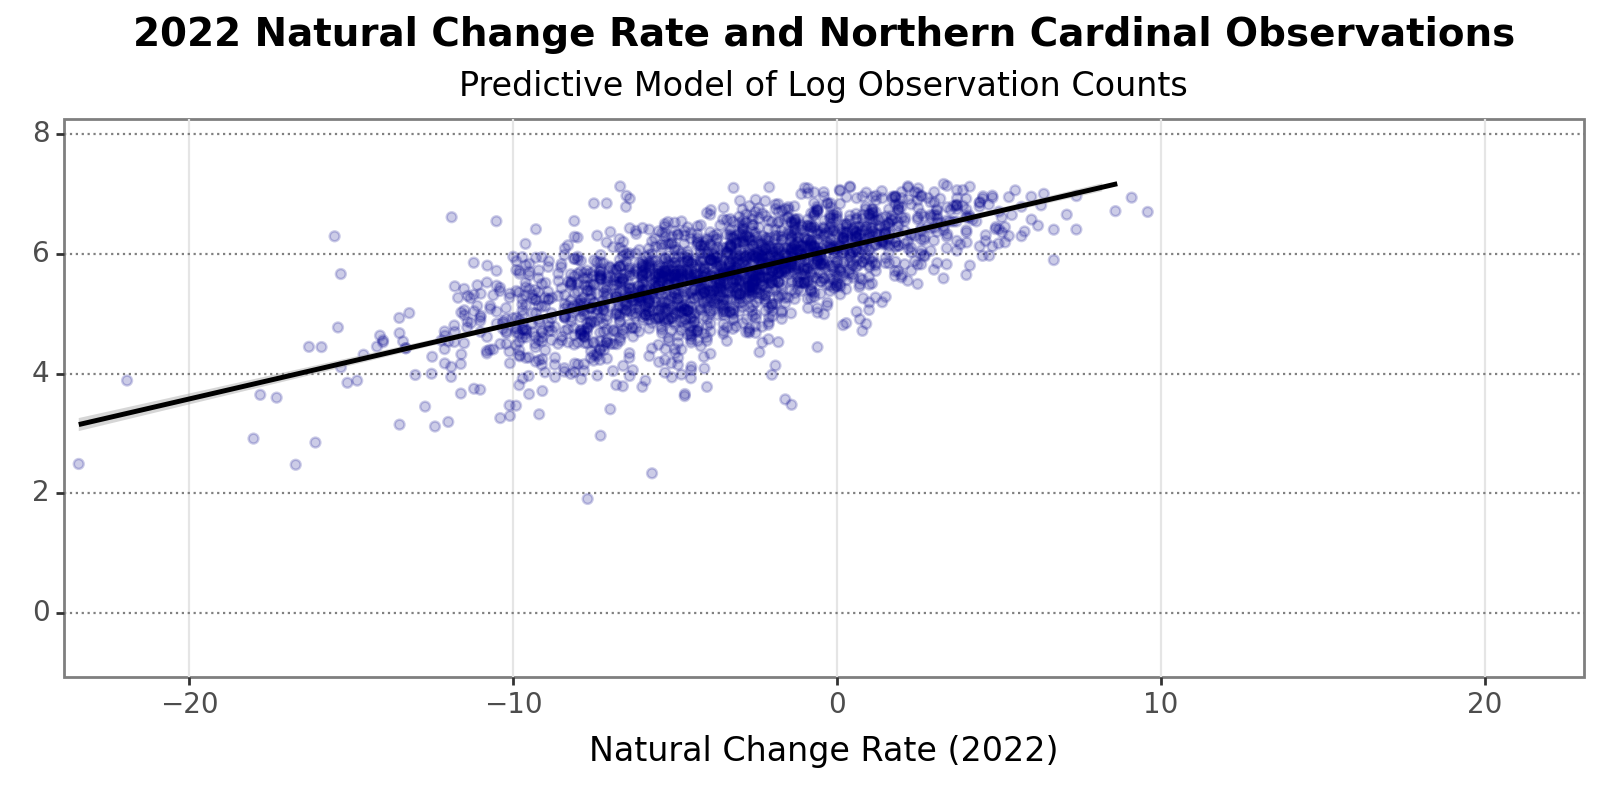



________________________________________________________________________________________________________________________




C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 86 rows containing missing values.


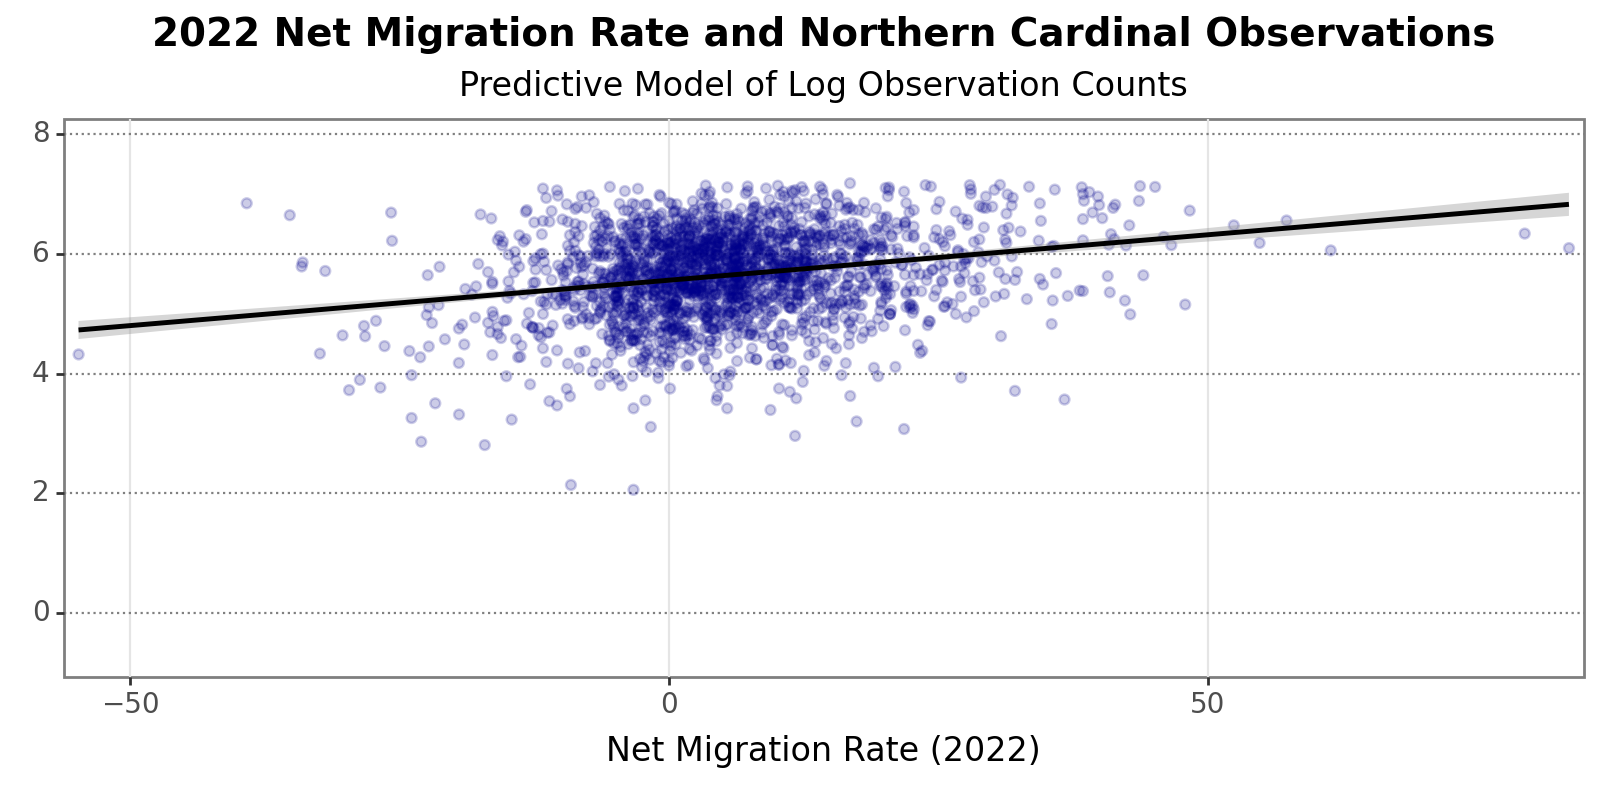

In [28]:
# Use the regression model to predict 'OBSERVATION_COUNT'
pred = reg29.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="R_NATURAL_CHG_2022", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="2022 Natural Change Rate and Northern Cardinal Observations",
        subtitle="Predictive Model of Log Observation Counts",
        x="Natural Change Rate (2022)",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)


plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x="R_NET_MIG_2022", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="2022 Net Migration Rate and Northern Cardinal Observations",
        subtitle="Predictive Model of Log Observation Counts",
        x="Net Migration Rate (2022)",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)

# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "pred_plot_4.png")
plot1.save(file_path_1, width=10, height=8, dpi=300)
# saving the plots to the folder
file_path_2 = os.path.join(folder_name, "pred_plot_5.png")
plot2.save(file_path_2, width=10, height=8, dpi=300)

print(plot1)
print("\n" + "_"*120 + "\n\n")
print(plot2)


### **3.4.3** Predictive Models from the OLS Regression of `ln_DURATION_MINUTES` and `ln_EFFORT_DISTANCE_KM` on `ln_OBSERVATION_COUNT`
---

C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_6.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 103 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_smooth : Removed 10 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: bird_plots\pred_plot_7.png
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 102 rows containing missing values.
C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 101 rows contai

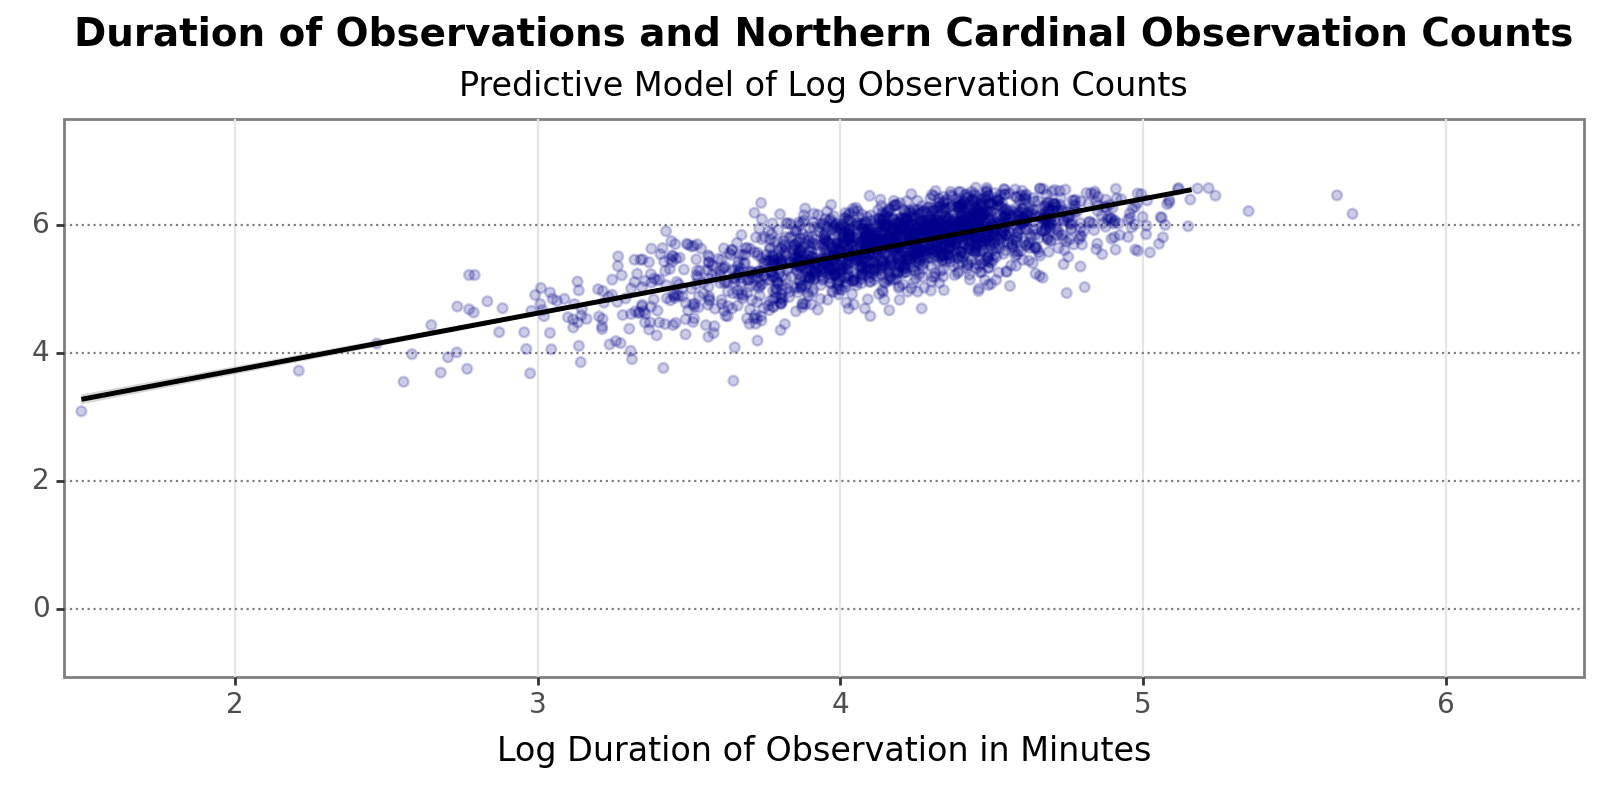



________________________________________________________________________________________________________________________




C:\Users\iandr\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_jitter : Removed 98 rows containing missing values.


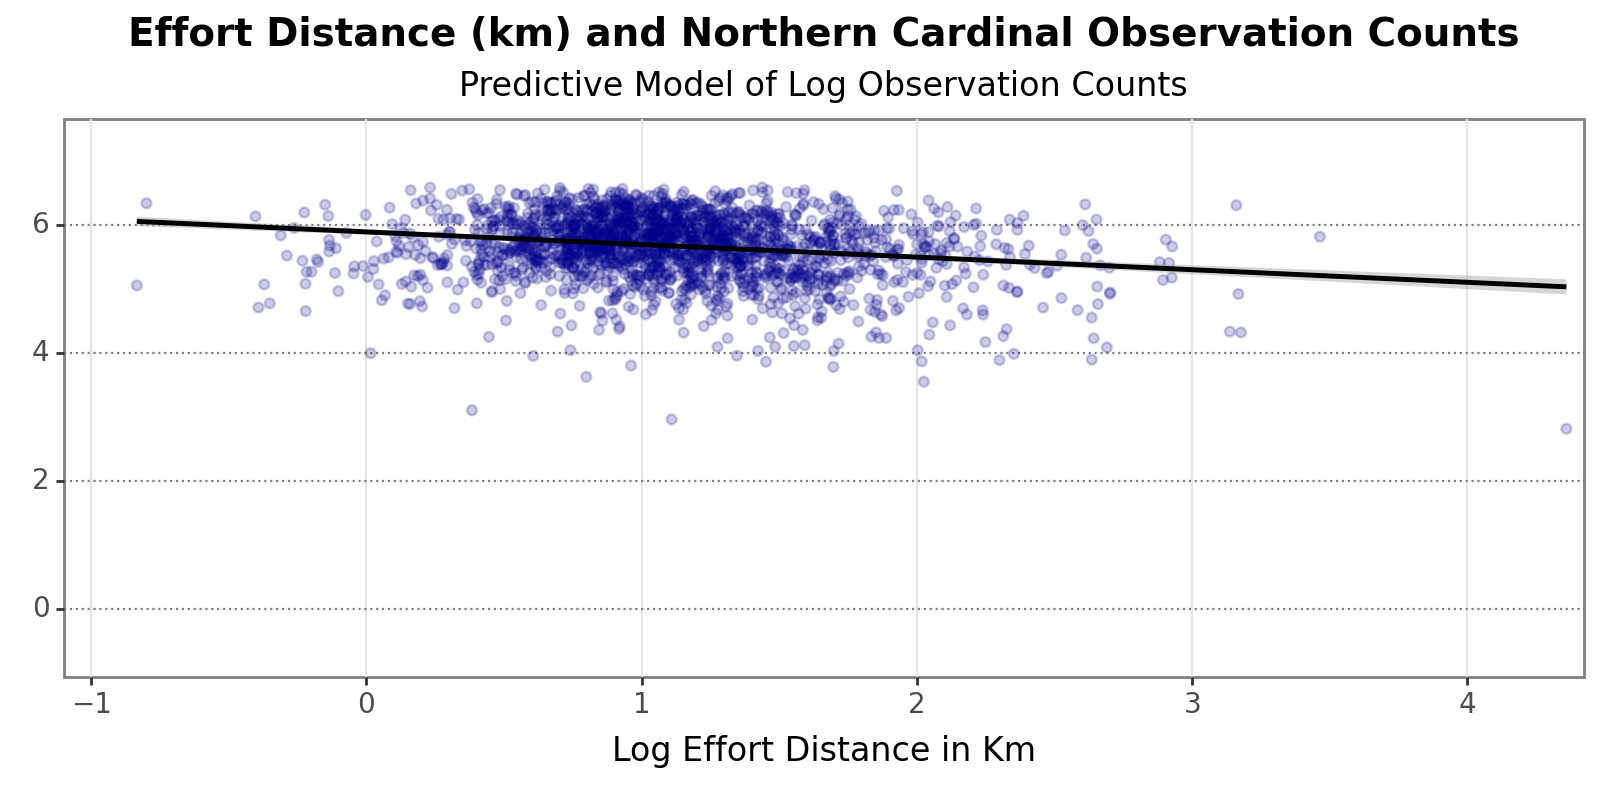

In [29]:
# Use the regression model to predict 'OBSERVATION_COUNT' based on the dataset
pred = reg27.get_prediction(county_norcar_merged_dummies).summary_frame()
county_norcar_merged_dummies = county_norcar_merged_dummies.assign(
    fit=pred["mean"],
    fit_se=pred["mean_se"],
    CIup=pred["mean_ci_upper"],
    CIlo=pred["mean_ci_lower"]
)

# Plotting the predictions along with their confidence intervals
plot1 = (
    ggplot(county_norcar_merged_dummies, aes(x="ln_DURATION_MINUTES", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="Duration of Observations and Northern Cardinal Observation Counts",
        subtitle="Predictive Model of Log Observation Counts",
        x="Log Duration of Observation in Minutes",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)


# Plotting the predictions along with their confidence intervals
plot2 = (
    ggplot(county_norcar_merged_dummies, aes(x="ln_EFFORT_DISTANCE_KM", y="fit")) +
    geom_jitter(alpha=0.2, size=1.5, color='darkblue') +  # Muted green color
    geom_smooth(method='lm', color='black', se=True) +  # Smoothing line for regression
    labs(
        title="Effort Distance (km) and Northern Cardinal Observation Counts",
        subtitle="Predictive Model of Log Observation Counts",
        x="Log Effort Distance in Km",
        y=""
    ) +
    theme_bw(base_size=12) +  # Minimal theme with base font size
    theme(
        plot_title=element_text(size=14, face="bold", hjust=0.5), # Centered title
        plot_subtitle=element_text(size=12, hjust=0.5),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_grid_major_y=element_line(color="grey", linetype="dotted"),  # Dotted major grid lines on y-axis
        figure_size=(8, 4)  # Aspect ratio of the plot, adjusted to your preference
    ) +
    scale_x_continuous(expand=(0.01, 0.01)) +  # Slight expansion for padding
    scale_y_continuous(
        limits=(0, county_norcar_merged_dummies['CIup'].quantile(0.95)),  # Limits for y-axis
        expand=(0.01, 1)  # Slight expansion for padding on y-axis
    )
)


# recalling the folder creation just as backup
folder_name = "bird_plots"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# saving the plots to the folder
file_path_1 = os.path.join(folder_name, "pred_plot_6.png")
plot1.save(file_path_1, width=10, height=8, dpi=300)
# saving the plots to the folder
file_path_2 = os.path.join(folder_name, "pred_plot_7.png")
plot2.save(file_path_2, width=10, height=8, dpi=300)

print(plot1) # duration of observations predictive model
print("\n" + "_"*120 + "\n\n")
print(plot2) # effort distance in km predictive model

# **4.** Generalization and external validity
---

The predictive models can be found nested under the regression models in section 3 *of the code*. 

Predictive models were applied to the OLS models' variables to validate the associations with log Northern Cardinal observation counts. These models further validated the negative association between urban influence, rural-urban continuum codes, and observation counts, as lower observations counts were associated with rural counties. Economic typology modelling indicated non-specialized counties and recreation dependent counties have the highest observation counts, with farming, mining, and manufacturing dependent counties showing lower counts. Predictive models for natural change rate, net immigration rate, observation duration, and effort distance yielded results like the OLS models in their association with observation counts, with negligible associations of natural change and net immigration rates, a positive association with longer observation durations, and a negative association with greater observation distances. These findings suggest that observation counts of the Northern Cardinal are positively associated with urbanization levels, with recreational areas having strong associations. Observation duration positively correlates with counts, whereas wider observation effort distances may lead to fewer observations. This underscores the potential influence of observation methods and urban development on bird observation frequencies.

---

# **5.** Causal Interpretation
---

Observation studies such as this cannot establish causality, but they can stimulate hypotheses for future research on the question. If in fact, urbanization does have a positive effect on the incidence of Northern Cardinal observation, it would lead to further research questions into what specific factors in the urbanized setting are causing this association. What other species of birds have similar associations with urbanization (e.g., ducks, geese, pigeons). Could the proportion of green space in a metropolitan setting influence this association? Could certainly urban settings demonstrate this association, while others do not? Does this association change based upon the industrial characteristics of the city?

The Urban Influence and Rural-Urban Continuum code models indicate a positive association between Northern Cardinal observations and urban development at the 1% significance threshold. This may reflect an attraction of these bird species to urbanized habitats, possibly due to food access and predator protection, despite initial concerns about observer bias in more populated areas. Economic typology models suggest a varying likelihood of observing backyard bird species across different urban habitats. Notably, recreation dependent counties, while not statistically significant, appear to host more of these species, contrasting with lower observation counts in farming, mining, and manufacturing dependent counties. This could be attributed to production sites destroying potential habitats for backyard bird species to reside, signifying the importance of environmental responsibility to preserve spaces for wildlife.

Regarding population dynamics, the small but statistically significant positive correlations of net immigration and natural change rates with bird observations suggest a potential link between higher human populations and more bird sightings. This might be due to easier food access for birds in human-dominated environments and increased likelihood of observation in more populated areas. Observation statistics further support these findings by showing longer observation durations positively correlate with higher bird counts, while greater travel distances during observations negatively impact counts. This aligns with the backyard habitat tendencies of Northern Cardinals, indicating that stationary observations in a single location, like a backyard, are more likely to yield higher observation counts.




---


# **6.** Conclusion
---

The results of this study on Northern Cardinals suggests that the incidence of observing backyard birds in the U.S. is positively associated with urbanization at the county level. Three potential possibilities could explain this observation: 1. more observers in urbanized environments are documenting more observations, or 2. urbanization is responsible for higher populations of Northern Cardinals; or 3. both explanations are present.

Future research that includes population density datasets in multiple linear regression models analyzing the association between urbanization and Northern Cardinal observation could control population density, assuming multicollinearity is not present. Further research will also need to be done on the association between urban development and non-adapted bird species to analyze the impact on non-backyard bird species.


---